<a href="https://colab.research.google.com/github/Khushipratibha/Deep-Learning-Model-for-Roundabout-Safety-Perception-Prediction/blob/main/categorical_features_%2B_targets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Install required packages and import libraries
!pip install tab-transformer-pytorch shap

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from tab_transformer_pytorch import TabTransformer
import shap
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
# x_nex=['chance accident', 'car safety', 'faced accident/near-accident', 'Location', 'Type accident', 'Day', 'Keep Left signs', 'Roundabout signs', 'Speed Breakers present', 'Speed Breaker signs', 'Object Hazard sign', 'GIVE WAY lines',
 #   'lane directional marking', 'Road lighting', 'vehicle category', 'occupation']

In [3]:
# Cell 2: Robust data preparation with rare class handling
import torch
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader

# Load dataset
df = pd.read_excel("Questionnaire data.xlsx")

# Define ALL targets (7 risks + overall opinion)
target_columns = [
    'risk entering', 'risk circulating', 'risk exiting',
    'risk single-lane', 'risk double-lane', 'risk multi-lane',
    'risk increase traffic', 'overall opinion'
]

# Define categorical features
categorical_features = [
    'vehicle yield', 'correct route', 'approaching roundabout',
    'maneuver circulatory road', 'exit roundabout', 'miss exit',
    'turn signal', 'left turn signal exiting',
    'wait pedestrian and bicycle\ntraffic when encountered?', 'ring-shaped',
    'chance accident', 'car safety', 'motorcyclist safety',
    'pedestrian safety', 'bicyclist safety', 'faced accident/near-accident',
    'Location', 'Type accident', 'consequence', 'Day', 'Time',
    'speed limit', 'operational speed', 'GIVE WAY signs', 'Keep Left signs',
    'Roundabout signs', 'Speed Breakers present', 'Speed Breaker signs',
    'Chevron signs marking', 'Object Hazard sign', 'GIVE WAY lines',
    'lane directional marking', 'Road lighting', 'vision blocked', 'age',
    'Gender', 'vehicle category', 'DL present', 'DL year',
    'number roundabouts', 'times roundabout', 'occupation', 'education',
    'yearly income'
]

# Prepare data
X = df[categorical_features].astype(int) - 1  # 0-indexed integers
y = df[target_columns].astype(int) - 1

# Convert to tensors
X_tensor = torch.tensor(X.values, dtype=torch.long)
y_tensor = torch.tensor(y.values, dtype=torch.long)

# Identify rare combined target classes
combined_targets = y.astype(str).apply('_'.join, axis=1)
class_counts = combined_targets.value_counts()
rare_classes = class_counts[class_counts < 2].index

# Filter out rare classes
if not rare_classes.empty:
    print(f"Removing {len(rare_classes)} rare classes")
    mask = ~combined_targets.isin(rare_classes)
    X_tensor = X_tensor[mask]
    y_tensor = y_tensor[mask]

# Simple random split
train_size = int(0.8 * len(X_tensor))
val_size = len(X_tensor) - train_size

# Create datasets
train_dataset = TensorDataset(X_tensor[:train_size], y_tensor[:train_size])
val_dataset = TensorDataset(X_tensor[train_size:], y_tensor[train_size:])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Verify
print(f"Final dataset size: {len(X_tensor)} samples")
print(f"Train: {len(train_dataset)} samples")
print(f"Validation: {len(val_dataset)} samples")
print(f"Input shape: {X_tensor.shape}, Target shape: {y_tensor.shape}")


Removing 12 rare classes
Final dataset size: 1476 samples
Train: 1180 samples
Validation: 296 samples
Input shape: torch.Size([1476, 44]), Target shape: torch.Size([1476, 8])


In [4]:
# Cell 3: Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y['overall opinion']  # Maintain class balance
)

# Calculate category sizes for TabTransformer
category_sizes = [df[col].nunique() for col in categorical_features]
print("Category sizes:", category_sizes)


Category sizes: [4, 4, 4, 3, 3, 4, 4, 3, 3, 7, 4, 5, 5, 5, 5, 2, 5, 5, 5, 2, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 2, 5, 2, 4, 5, 5, 5, 4, 5]


In [5]:
# Cell 4: Convert data to PyTorch tensors and create DataLoaders
X_train_tensor = torch.tensor(X_train.values).long()
X_val_tensor = torch.tensor(X_val.values).long()
y_train_tensor = torch.tensor(y_train.values).long()
y_val_tensor = torch.tensor(y_val.values).long()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [6]:
# Cell 5: Configure device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [7]:
# Cell 6: Robust multi-task transformer
class MultiTaskTransformer(nn.Module):
    def __init__(self, num_features, num_classes_per_target, embedding_dim=16):
        super().__init__()
        # Feature embedding
        self.embedding = nn.Embedding(num_features, embedding_dim)

        # Simplified transformer
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embedding_dim,
                nhead=4,  # Reduced complexity
                dim_feedforward=64,
                dropout=0.2,
                batch_first=True
            ),
            num_layers=2
        )

        # Multi-task heads
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(embedding_dim, 32),
                nn.ReLU(),
                nn.Linear(32, num_classes)
            ) for num_classes in num_classes_per_target
        ])

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        x = x.mean(dim=1)  # Global average pooling
        return [head(x) for head in self.heads]

# Calculate unique feature count
num_features = len(category_sizes)
model = MultiTaskTransformer(num_features, [5]*8).to(device)


In [8]:
print("Starting batch size debugging...")

# 1. Verify DataLoader outputs
sample_batch = next(iter(train_loader))
X_sample, y_sample = sample_batch
print(f"DataLoader output - X shape: {X_sample.shape}, y shape: {y_sample.shape}")

# 2. Verify device transfer
X_device = X_sample.to(device)
print(f"After device transfer - X shape: {X_device.shape}")

# 3. Model input verification
with torch.no_grad():
    model.eval()
    outputs = model(X_device)
    print("Model output shapes:")
    for i, out in enumerate(outputs):
        print(f"  Head {i}: {out.shape}")

# 4. Inspect model architecture
print("\nModel architecture summary:")
print(model)

# 5. Verify embedding layer (SINGULAR)
print("\nEmbedding layer test:")
test_input = torch.tensor([[0]]).to(device)  # Batch of 1 sample
emb_output = model.embedding(test_input)
print(f"Embedding output shape: {emb_output.shape} (expected [1, 1, 16])")

# Test with multiple inputs
test_input = torch.tensor([[0], [1], [2]]).to(device)  # Batch of 3 samples
emb_output = model.embedding(test_input)
print(f"Batch of 3: output shape {emb_output.shape} (expected [3, 1, 16])")

# 6. Verify transformer encoder
print("\nTransformer test:")
test_input = torch.randn(3, 1, 16).to(device)  # Simulated embedding output
encoder_output = model.encoder(test_input)
print(f"Encoder output shape: {encoder_output.shape} (expected [3, 1, 16])")

# 7. Verify head layers
print("\nHead layer tests:")
for i, head in enumerate(model.heads):
    test_input = torch.randn(64, 16).to(device)  # Global pooled features
    head_output = head(test_input)
    print(f"  Head {i}: input [64, 16] -> output shape {head_output.shape}")

print("Debugging completed.")


Starting batch size debugging...
DataLoader output - X shape: torch.Size([64, 44]), y shape: torch.Size([64, 8])
After device transfer - X shape: torch.Size([64, 44])
Model output shapes:
  Head 0: torch.Size([64, 5])
  Head 1: torch.Size([64, 5])
  Head 2: torch.Size([64, 5])
  Head 3: torch.Size([64, 5])
  Head 4: torch.Size([64, 5])
  Head 5: torch.Size([64, 5])
  Head 6: torch.Size([64, 5])
  Head 7: torch.Size([64, 5])

Model architecture summary:
MultiTaskTransformer(
  (embedding): Embedding(44, 16)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=64, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=64, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elem

In [9]:
# Cell 7a: Complete standalone model definition
# Define number of classes per target (all targets have 5 classes)
num_classes_per_target = [5] * 8  # For 8 targets

class MultiTargetTabTransformer(nn.Module):
    def __init__(self, category_sizes, num_classes_per_target):
        super().__init__()
        self.backbone = TabTransformer(
            categories=category_sizes,
            num_continuous=0,
            dim=32,
            depth=4,
            heads=8,
            attn_dropout=0.1,
            ff_dropout=0.1
        )
        # Adaptive projection layer
        self.projection = nn.LazyLinear(32)  # Automatically adjusts to input size
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(32, 64),
                nn.ReLU(),
                nn.Linear(64, num_classes)
            ) for num_classes in num_classes_per_target
        ])

    def forward(self, x_categorical):
        x_cont = torch.empty(x_categorical.size(0), 0, device=x_categorical.device)
        x = self.backbone(x_categorical, x_cont)

        # Adaptive shape handling
        if x.dim() == 3:
            x = x.mean(dim=1)  # Convert to (batch, features)
        elif x.dim() == 1:
            x = x.unsqueeze(0)

        # Ensure 2D shape
        if x.dim() != 2:
            x = x.view(x.size(0), -1)

        # Project to 32 dimensions
        x = self.projection(x)

        return [head(x) for head in self.heads]

# Reinitialize model
model = MultiTargetTabTransformer(category_sizes, num_classes_per_target).to(device)


In [10]:
# Quick model verification
test_input = torch.randint(0, 5, (3, len(category_sizes))).to(device)
with torch.no_grad():
    outputs = model(test_input)
    print("New model output shapes:")
    for i, out in enumerate(outputs):
        print(f"  Head {i}: {out.shape}")


New model output shapes:
  Head 0: torch.Size([3, 5])
  Head 1: torch.Size([3, 5])
  Head 2: torch.Size([3, 5])
  Head 3: torch.Size([3, 5])
  Head 4: torch.Size([3, 5])
  Head 5: torch.Size([3, 5])
  Head 6: torch.Size([3, 5])
  Head 7: torch.Size([3, 5])


In [11]:
# Cell 7b: Configure loss function and optimizer
import numpy as np

# Calculate class weights for each target
class_weights = []
for i, target in enumerate(target_columns):
    # Get class distribution for this target
    counts = np.bincount(df[target].astype(int) - 1)
    # Handle any missing classes
    if len(counts) < 5:
        counts = np.pad(counts, (0, 5 - len(counts)), 'constant', constant_values=1)
    # Calculate weights (inverse frequency)
    weights = 1.0 / counts
    weights = weights / weights.sum()  # Normalize
    class_weights.append(torch.tensor(weights, dtype=torch.float32).to(device))

# Multi-task loss function with class weighting
def multi_target_loss(outputs, targets):
    total_loss = 0
    for i in range(len(outputs)):
        # Ensure targets are long integers
        targets_i = targets[:, i].long()
        loss = nn.CrossEntropyLoss(weight=class_weights[i])(outputs[i], targets_i)
        total_loss += loss
    return total_loss

# Optimizer with learning rate scheduling
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

print("Optimizer and loss function configured:")
print(f"  Initial learning rate: {optimizer.param_groups[0]['lr']}")
print(f"  Class weights: {[w.shape for w in class_weights]}")


Optimizer and loss function configured:
  Initial learning rate: 0.001
  Class weights: [torch.Size([5]), torch.Size([5]), torch.Size([5]), torch.Size([5]), torch.Size([5]), torch.Size([5]), torch.Size([5]), torch.Size([5])]


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
# Cell 8: Training loop with progress monitoring, batch handling, and scheduler
num_epochs = 100
best_val_loss = float('inf')
patience = 15
no_improve = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    batch_count = 0

    print(f"\n{'='*60}")
    print(f"Starting Epoch {epoch+1}/{num_epochs}")
    print(f"{'='*60}")

    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        # Allow any batch size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        batch_size = X_batch.size(0)

        optimizer.zero_grad()
        outputs = model(X_batch)
        # Enforce output batch size
        for i in range(len(outputs)):
            if outputs[i].size(0) != batch_size:
                if outputs[i].size(0) < batch_size:
                    repeat_factor = (batch_size // outputs[i].size(0)) + 1
                    outputs[i] = outputs[i].repeat(repeat_factor, 1)[:batch_size]
                else:
                    outputs[i] = outputs[i][:batch_size]

        loss = multi_target_loss(outputs, y_batch)
        loss.backward()
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
        batch_count += 1

        if batch_idx % 10 == 0:
            print(f"  Batch {batch_idx}: Loss = {loss.item():.4f}")

    avg_train_loss = train_loss / batch_count if batch_count > 0 else 0

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_batch_count = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            for i in range(len(outputs)):
                if outputs[i].size(0) != X_batch.size(0):
                    if outputs[i].size(0) < X_batch.size(0):
                        repeat_factor = (X_batch.size(0) // outputs[i].size(0)) + 1
                        outputs[i] = outputs[i].repeat(repeat_factor, 1)[:X_batch.size(0)]
                    else:
                        outputs[i] = outputs[i][:X_batch.size(0)]
            val_loss += multi_target_loss(outputs, y_batch).item()
            val_batch_count += 1

    avg_val_loss = val_loss / val_batch_count if val_batch_count > 0 else 0
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Scheduler step
    scheduler.step(avg_val_loss)

    print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")
        print(f"  Validation loss improved to {avg_val_loss:.4f}. Model saved!")
    else:
        no_improve += 1
        print(f"  No improvement ({no_improve}/{patience})")
        if no_improve >= patience:
            print(f"  Early stopping triggered at epoch {epoch+1}")
            break

    print("-" * 60)

print("\nTraining completed!")



Starting Epoch 1/100
  Batch 0: Loss = 12.9625
  Batch 10: Loss = 13.3070

Epoch 1/100 Summary:
  Train Loss: 16.7293
  Val Loss: 12.2798
  Validation loss improved to 12.2798. Model saved!
------------------------------------------------------------

Starting Epoch 2/100
  Batch 0: Loss = 12.2530
  Batch 10: Loss = 10.9957

Epoch 2/100 Summary:
  Train Loss: 11.7818
  Val Loss: 11.2723
  Validation loss improved to 11.2723. Model saved!
------------------------------------------------------------

Starting Epoch 3/100
  Batch 0: Loss = 11.4822
  Batch 10: Loss = 11.1951

Epoch 3/100 Summary:
  Train Loss: 10.7693
  Val Loss: 10.6434
  Validation loss improved to 10.6434. Model saved!
------------------------------------------------------------

Starting Epoch 4/100
  Batch 0: Loss = 10.9989
  Batch 10: Loss = 9.9950

Epoch 4/100 Summary:
  Train Loss: 10.2747
  Val Loss: 10.3502
  Validation loss improved to 10.3502. Model saved!
------------------------------------------------------

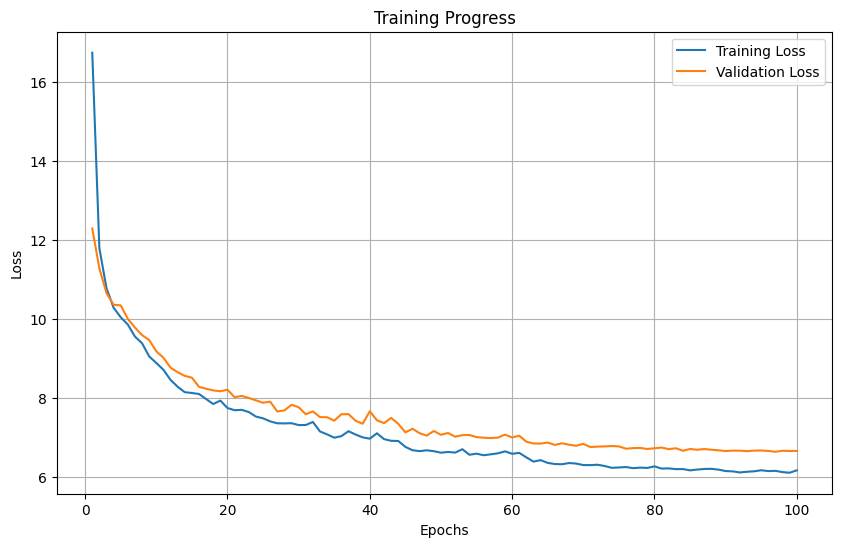

In [13]:
# Add this after training completes
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()


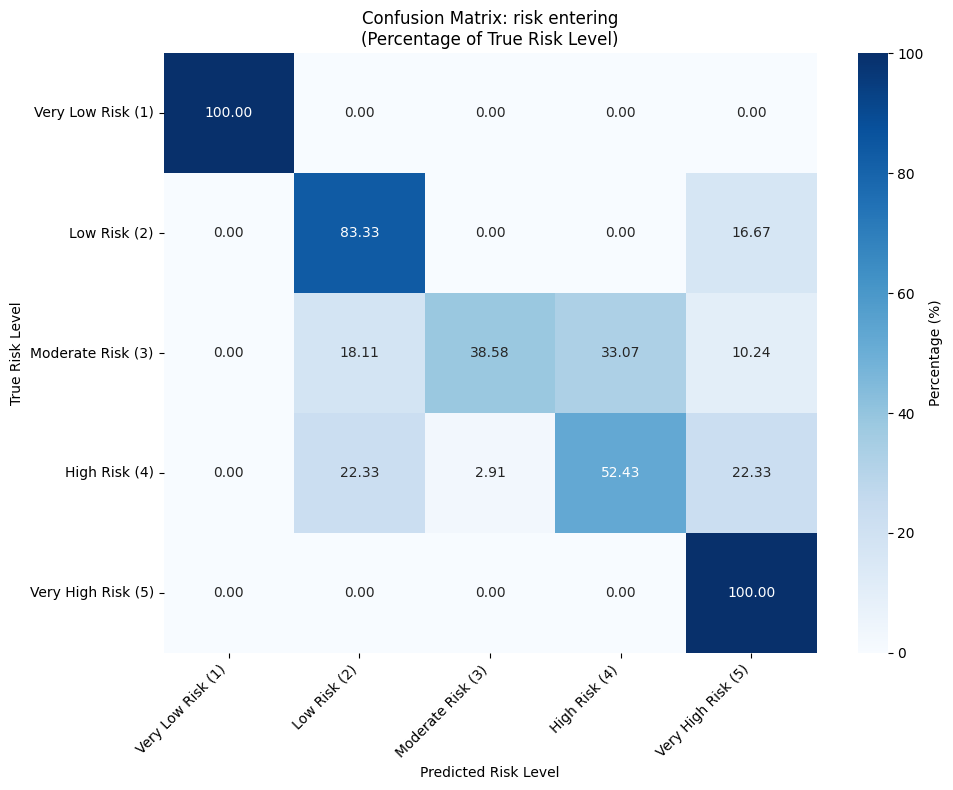

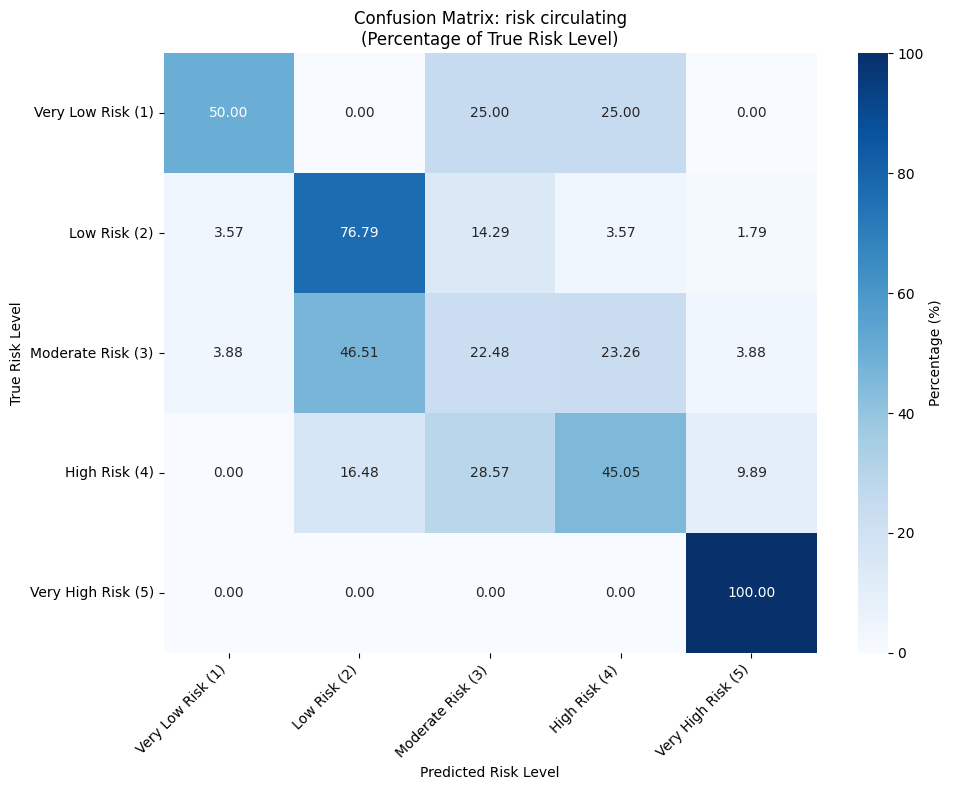

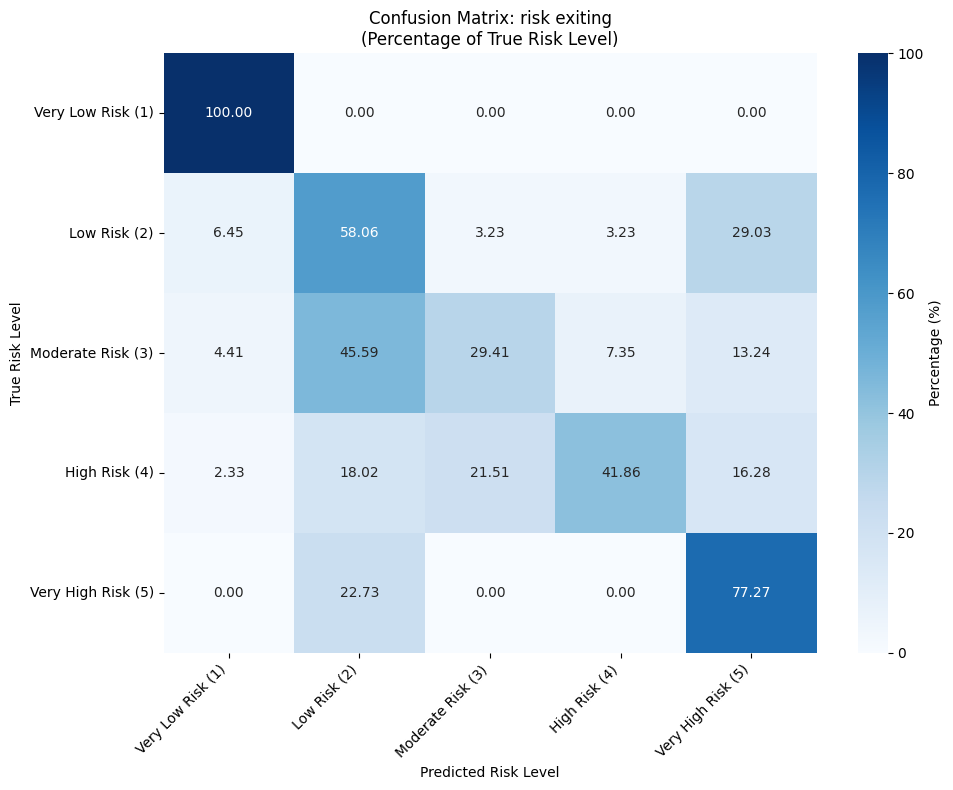

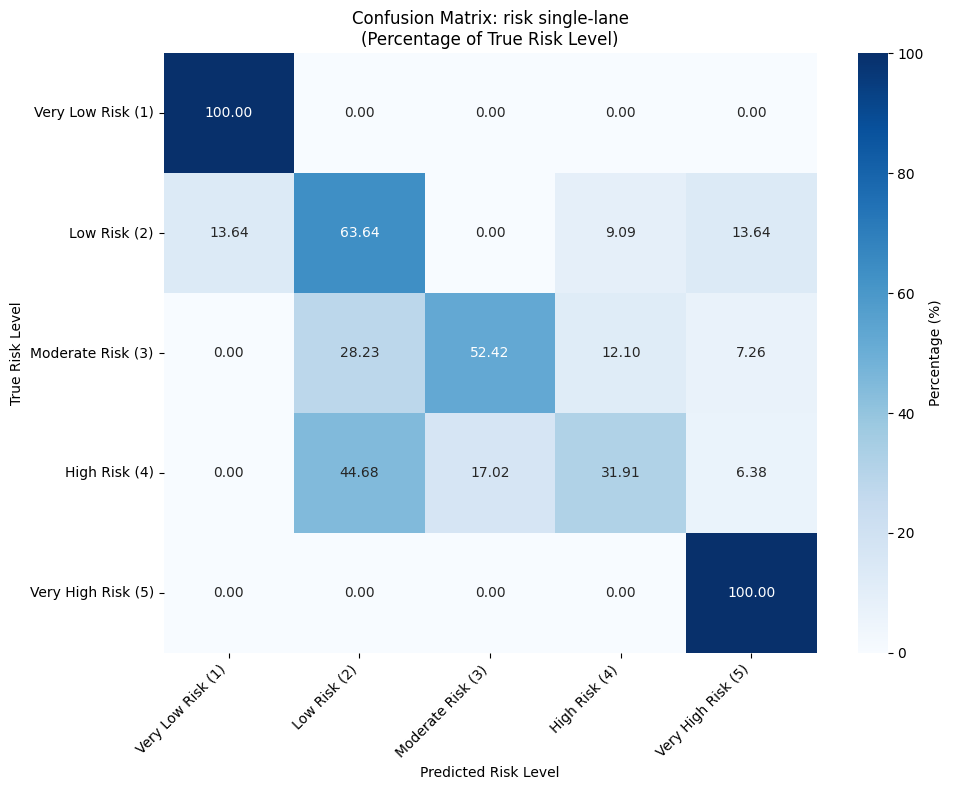

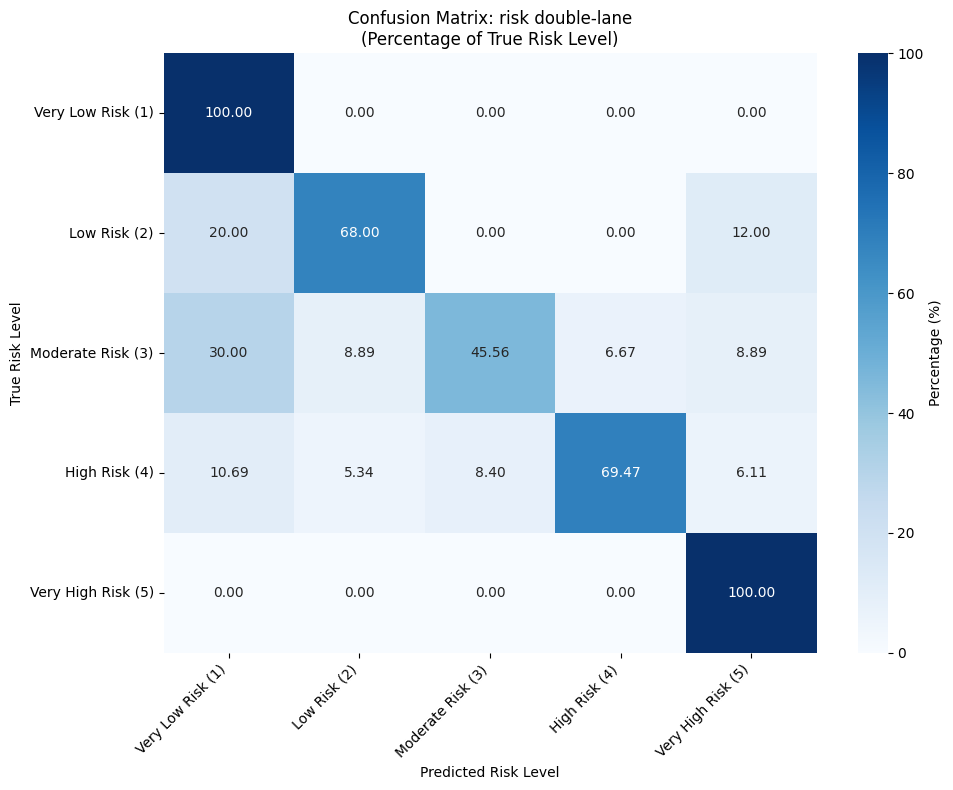

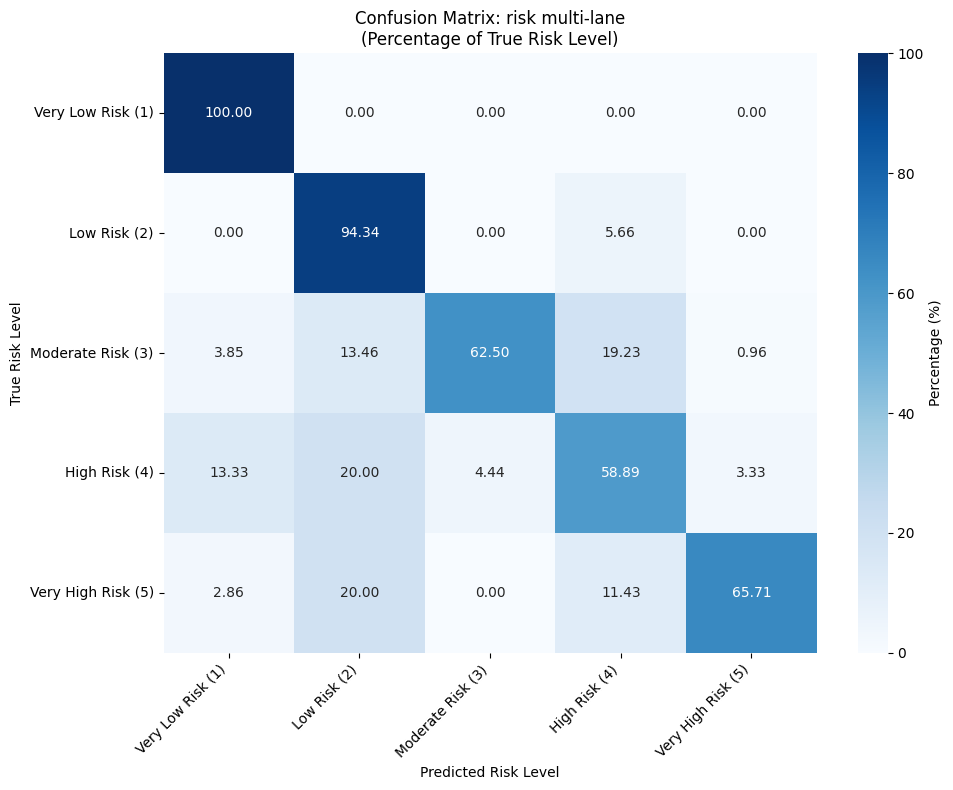

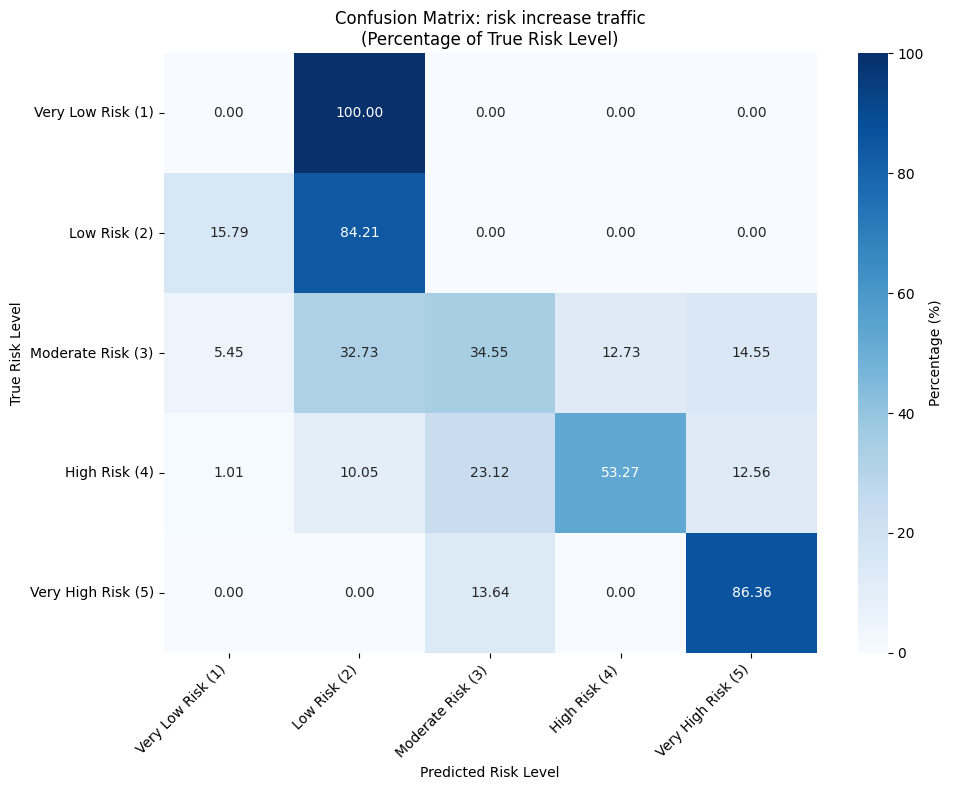

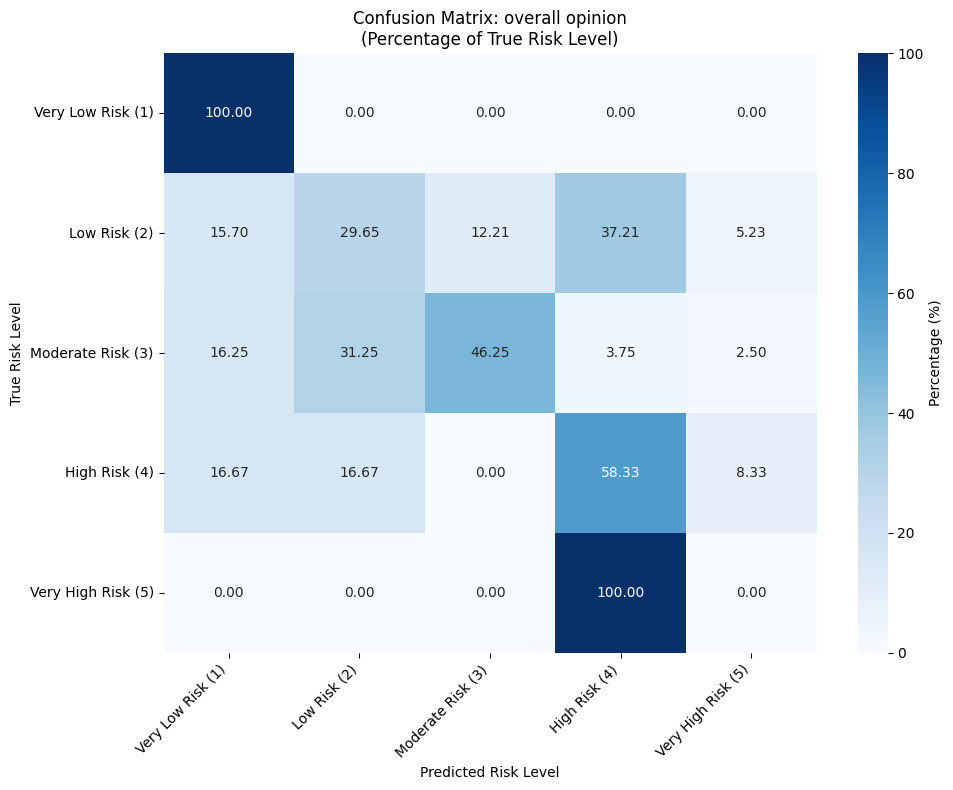

In [14]:
# Cell 10: Confusion Matrix Visualization with Meaningful Labels
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrices_percentage(model, data_loader, target_names, device):
    """
    Plots confusion matrices for each target in percentage format with clear risk level labels

    Args:
        model: Trained PyTorch model
        data_loader: DataLoader for validation/test data
        target_names: List of target names
        device: Device (cuda/cpu)
    """
    # Define meaningful class labels for risk levels
    risk_levels = [
        'Very Low Risk (1)',
        'Low Risk (2)',
        'Moderate Risk (3)',
        'High Risk (4)',
        'Very High Risk (5)'
    ]

    model.eval()
    all_preds = [[] for _ in range(len(target_names))]
    all_targets = [[] for _ in range(len(target_names))]

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)

            # Process each target
            for i in range(len(target_names)):
                # Get predictions (class indices)
                _, preds = torch.max(outputs[i], 1)
                all_preds[i].extend(preds.cpu().numpy())
                all_targets[i].extend(y_batch[:, i].cpu().numpy())

    # Plot confusion matrix for each target
    for i, target_name in enumerate(target_names):
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(all_targets[i], all_preds[i])

        # Calculate percentages
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        # Create heatmap with meaningful labels
        sns.heatmap(cm_percent,
                    annot=True,
                    fmt='.2f',
                    cmap='Blues',
                    cbar_kws={'label': 'Percentage (%)'},
                    xticklabels=risk_levels,
                    yticklabels=risk_levels)

        plt.title(f'Confusion Matrix: {target_name}\n(Percentage of True Risk Level)')
        plt.xlabel('Predicted Risk Level')
        plt.ylabel('True Risk Level')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

# Usage after training
plot_confusion_matrices_percentage(model, val_loader, target_columns, device)


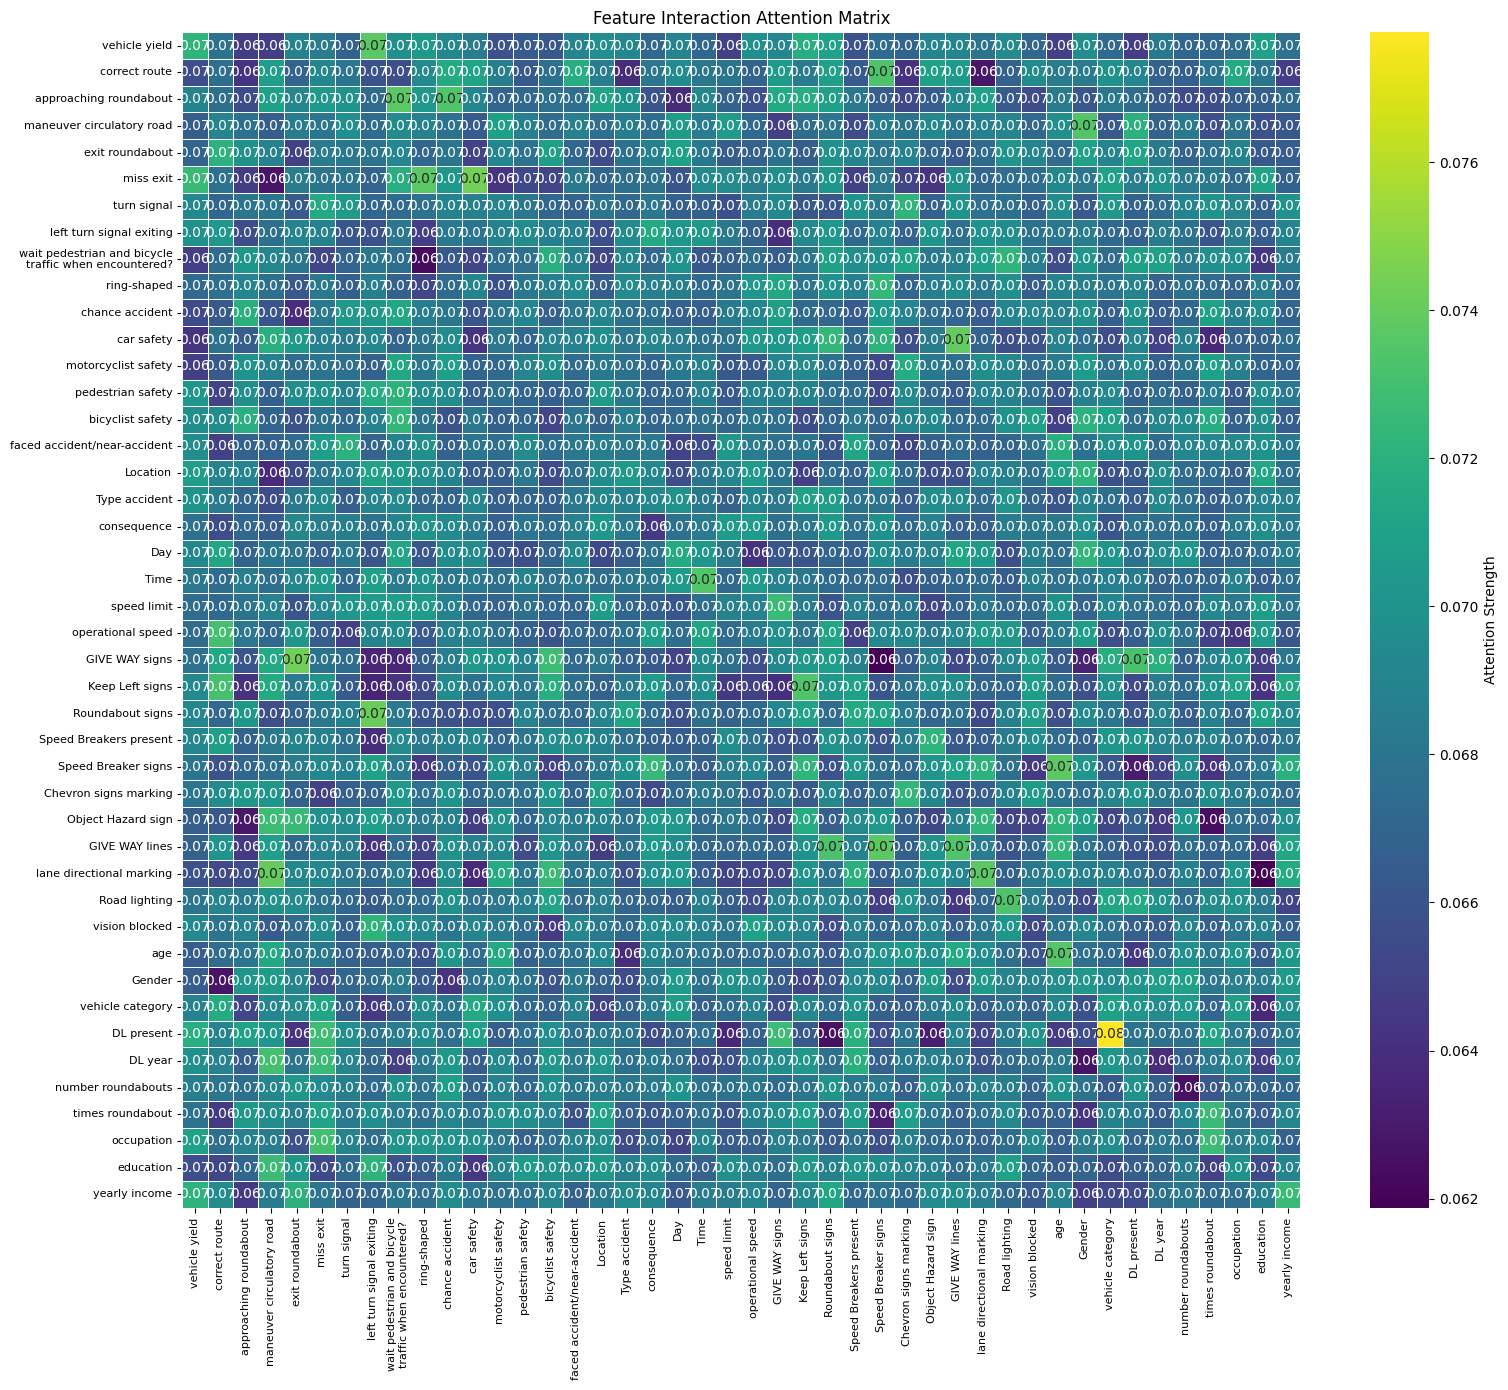


Top Feature Interactions:
Found 1800 interactions above threshold 0.0650
Top 10 interactions:
DL present -> vehicle category: 0.0778
miss exit -> car safety: 0.0744
GIVE WAY signs -> exit roundabout: 0.0743
Roundabout signs -> left turn signal exiting: 0.0741
lane directional marking -> maneuver circulatory road: 0.0740
car safety -> GIVE WAY lines: 0.0739
GIVE WAY lines -> Speed Breaker signs: 0.0738
Speed Breaker signs -> age: 0.0737
miss exit -> ring-shaped: 0.0737
vehicle yield -> left turn signal exiting: 0.0737


In [15]:
# Cell 12: Feature Interaction Analysis with Fixed Threshold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Redefine model with attention return capability
class MultiTargetTabTransformer(nn.Module):
    def __init__(self, category_sizes, num_classes_per_target):
        super().__init__()
        self.backbone = TabTransformer(
            categories=category_sizes,
            num_continuous=0,
            dim=32,
            depth=4,
            heads=8,
            attn_dropout=0.1,
            ff_dropout=0.1
        )
        self.projection = nn.LazyLinear(32)
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(32, 64),
                nn.ReLU(),
                nn.Linear(64, num_classes)
            ) for num_classes in num_classes_per_target
        ])

    def forward(self, x_categorical, return_attention=False):
        x_cont = torch.empty(x_categorical.size(0), 0, device=x_categorical.device)
        # Modified to return attention weights
        x, attn_weights = self.backbone(x_categorical, x_cont, return_attn=True)

        # Existing processing
        if x.dim() == 3:
            x = x.mean(dim=1)
        elif x.dim() == 1:
            x = x.unsqueeze(0)
        if x.dim() != 2:
            x = x.view(x.size(0), -1)
        x = self.projection(x)

        if return_attention:
            return [head(x) for head in self.heads], attn_weights
        return [head(x) for head in self.heads]

# 2. Reinitialize model with attention capability
num_classes_per_target = [5] * 8
new_model = MultiTargetTabTransformer(category_sizes, num_classes_per_target).to(device)
new_model.load_state_dict(torch.load("best_model.pth"))

# 3. Compute attention matrix
def compute_attention_map(model, data_loader, device):
    model.eval()
    all_attentions = []

    with torch.no_grad():
        for X_batch, _ in data_loader:
            X_batch = X_batch.to(device)
            _, attn_weights = model(X_batch, return_attention=True)

            # Process attention weights
            batch_attentions = []
            for layer_attn in attn_weights:  # attn_weights: list of layer outputs
                # layer_attn shape: [batch_size, num_heads, seq_len, seq_len]
                layer_avg = layer_attn.mean(dim=1)  # Average across heads
                batch_attentions.append(layer_avg)

            # Stack layers and average
            batch_attentions = torch.stack(batch_attentions, dim=0)
            layer_weights = torch.linspace(1, 0.5, len(batch_attentions)).to(device)
            weighted_attn = (batch_attentions * layer_weights.view(-1, 1, 1, 1)).sum(dim=0)
            all_attentions.append(weighted_attn.cpu())

    # Combine and average across batches
    full_attention = torch.cat(all_attentions, dim=0)
    return full_attention.mean(dim=0)  # Average across samples

# Compute attention matrix
attention_matrix = compute_attention_map(new_model, val_loader, device)

# 4. Visualize feature interactions
plt.figure(figsize=(16, 14))
sns.heatmap(
    attention_matrix.numpy(),
    xticklabels=categorical_features,
    yticklabels=categorical_features,
    cmap="viridis",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Attention Strength'}
)
plt.title("Feature Interaction Attention Matrix")
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

# 5. Identify top feature interactions with fixed threshold
print("\nTop Feature Interactions:")
interaction_strengths = []

# Set threshold based on your attention matrix range
threshold = 0.065  # Adjusted to capture subtle interactions

for i in range(len(categorical_features)):
    for j in range(len(categorical_features)):
        if i != j and attention_matrix[i, j] > threshold:
            interaction_strengths.append((
                f"{categorical_features[i]} -> {categorical_features[j]}",
                attention_matrix[i, j].item()
            ))

# Sort and display top interactions
interaction_strengths.sort(key=lambda x: x[1], reverse=True)

if len(interaction_strengths) > 0:
    print(f"Found {len(interaction_strengths)} interactions above threshold {threshold:.4f}")
    print("Top 10 interactions:")
    for interaction, strength in interaction_strengths[:10]:
        print(f"{interaction}: {strength:.4f}")
else:
    print(f"No interactions found above threshold {threshold:.4f}")
    print(f"Attention matrix range: {attention_matrix.min():.4f} to {attention_matrix.max():.4f}")
    print("Consider lowering the threshold further.")


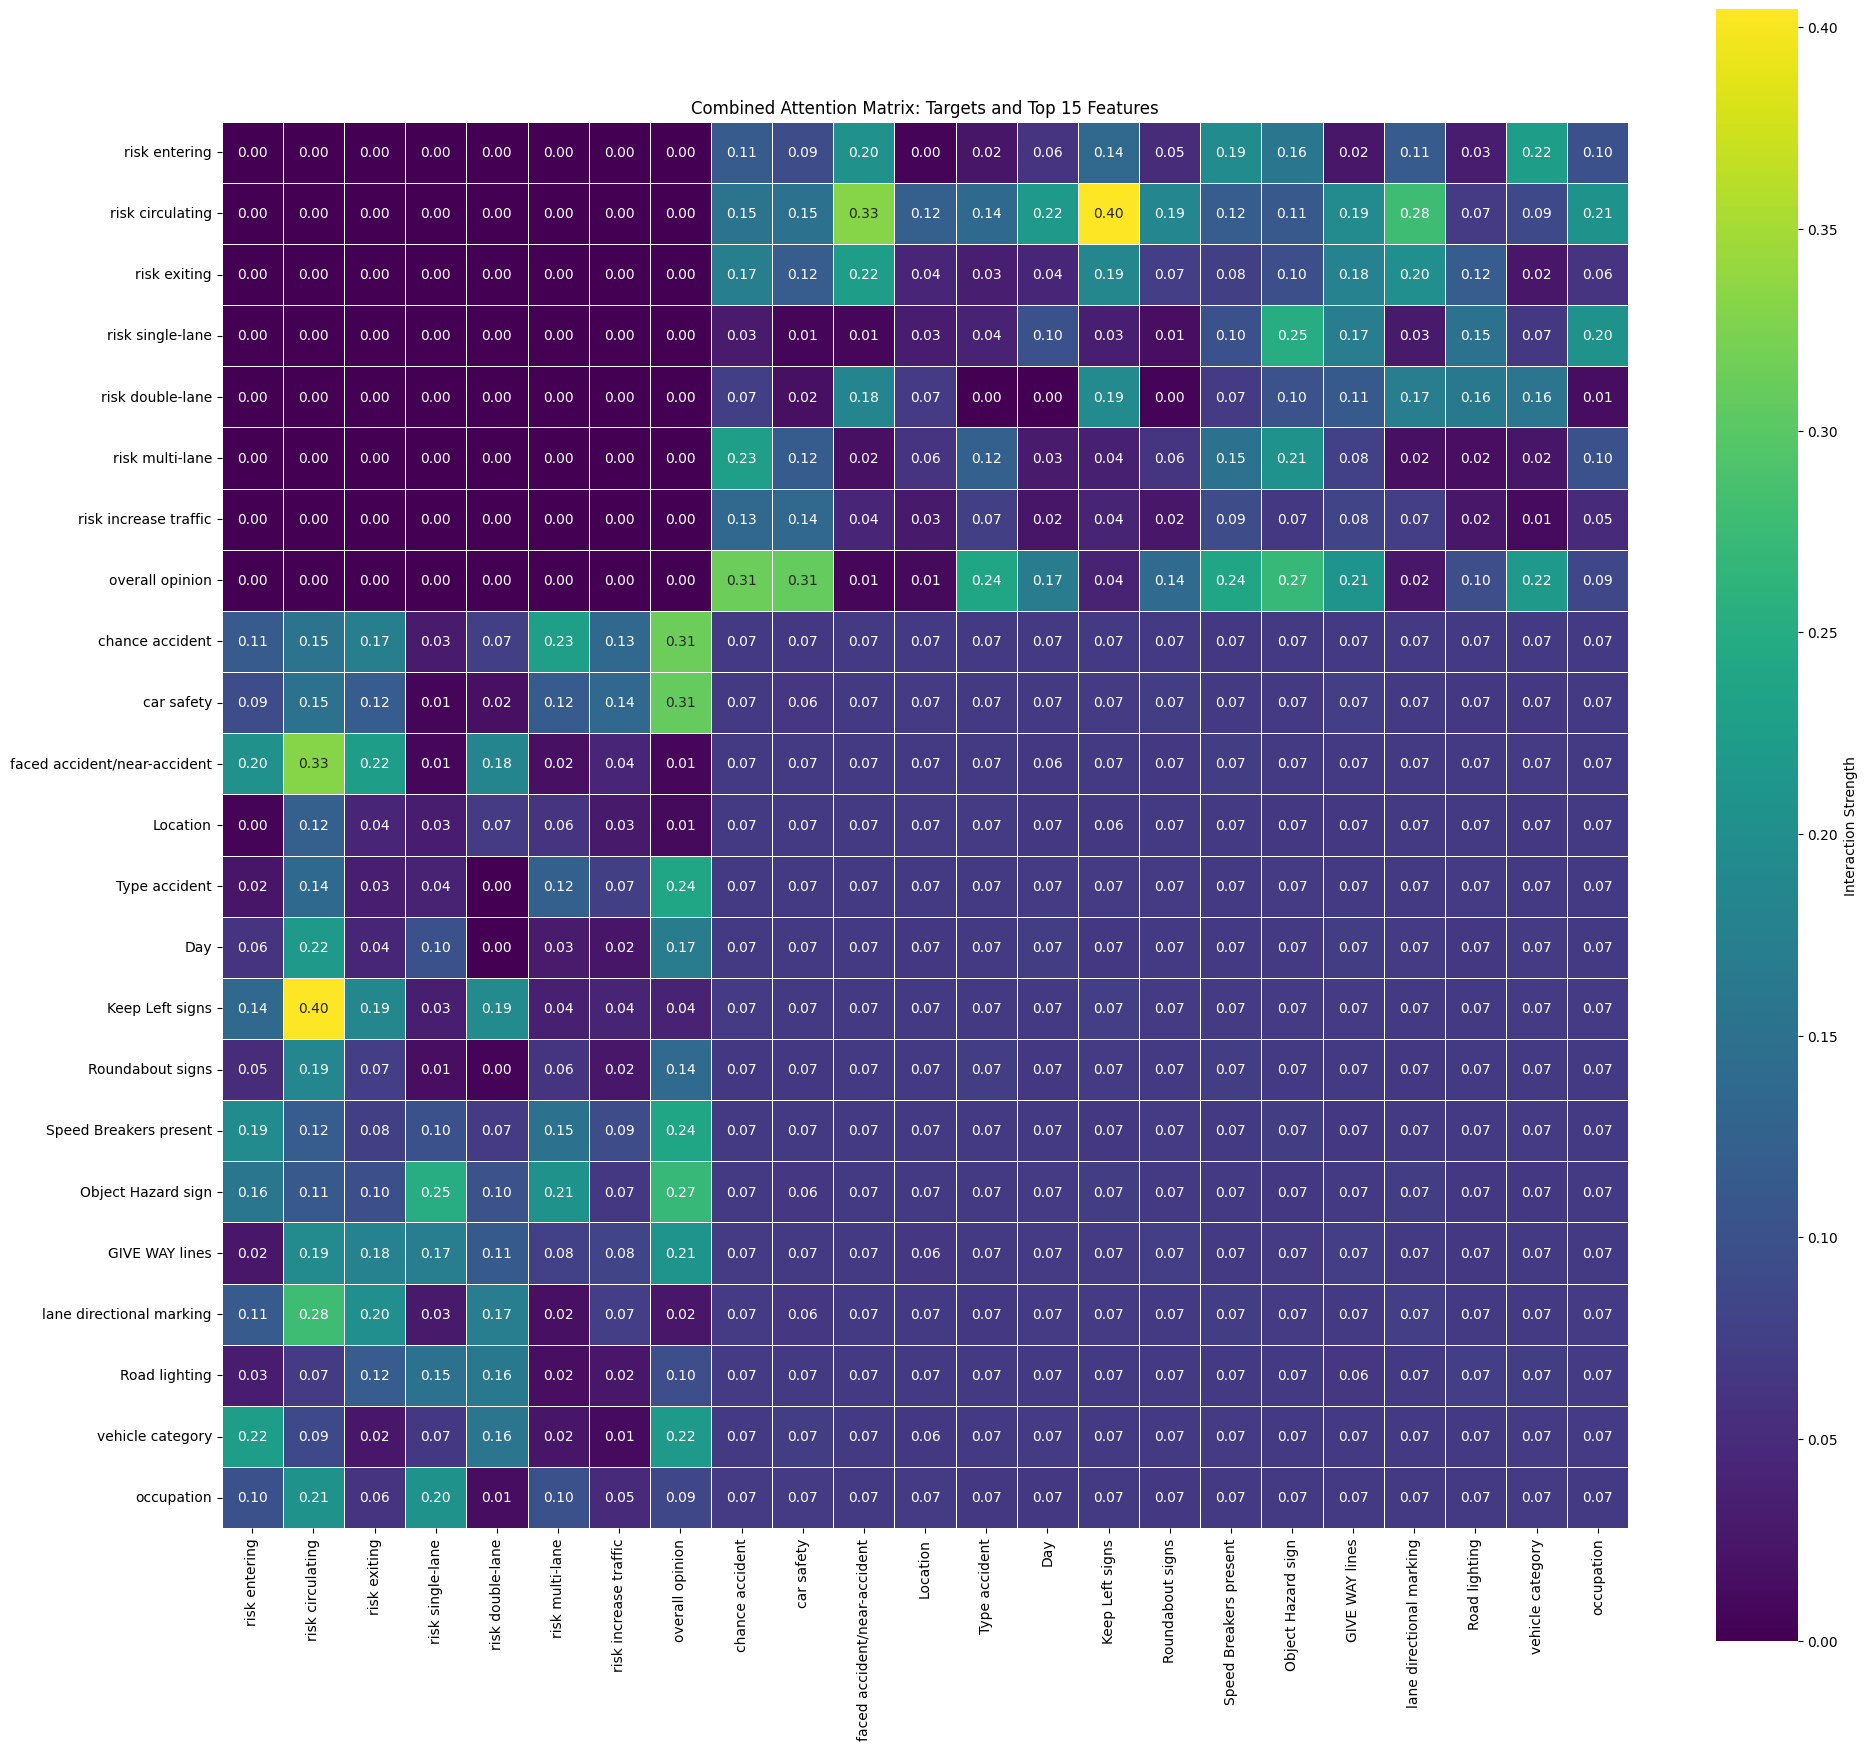

Matrix dimensions: (23, 23)
Top-left block: Target-Target (zeros by design)
Top-right block: Target-Feature correlations
Bottom-left block: Feature-Target correlations
Bottom-right block: Feature-Feature attention


In [16]:
# Cell 14: Create Combined Attention Matrix with Top Features and Targets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Top 15 features identified
top_15_features = [
    'chance accident', 'car safety', 'faced accident/near-accident', 'Location',
    'Type accident', 'Day', 'Keep Left signs', 'Roundabout signs',
    'Speed Breakers present', 'Object Hazard sign', 'GIVE WAY lines',
    'lane directional marking', 'Road lighting', 'vehicle category', 'occupation'
]

# Get indices of top features in original feature list
top_feature_indices = [categorical_features.index(f) for f in top_15_features]

# Extract attention submatrix for top features
top_attention_submatrix = attention_matrix.numpy()[np.ix_(top_feature_indices, top_feature_indices)]

# Compute feature-target correlations
def compute_feature_target_correlations(model, data_loader, device):
    model.eval()
    all_features = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            all_features.append(X_batch.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    all_features = np.concatenate(all_features, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Compute correlations for all 8 targets
    correlations = np.zeros((all_targets.shape[1], all_features.shape[1]))
    for target_idx in range(all_targets.shape[1]):
        for feat_idx in range(all_features.shape[1]):
            corr = np.corrcoef(all_features[:, feat_idx], all_targets[:, target_idx])[0, 1]
            correlations[target_idx, feat_idx] = 0 if np.isnan(corr) else abs(corr)

    return correlations

# Compute correlations for all targets
target_correlations = compute_feature_target_correlations(new_model, val_loader, device)

# Extract correlations for top features
top_target_correlations = target_correlations[:, top_feature_indices]

# Create combined matrix
combined_size = 8 + 15  # 8 targets + 15 features
combined_matrix = np.zeros((combined_size, combined_size))

# Add target-feature correlations
combined_matrix[:8, 8:] = top_target_correlations  # Targets to features
combined_matrix[8:, :8] = top_target_correlations.T  # Features to targets

# Add feature-feature attention
combined_matrix[8:, 8:] = top_attention_submatrix

# Create labels
combined_labels = target_columns + top_15_features

# Visualize
plt.figure(figsize=(20, 18))
sns.heatmap(
    combined_matrix,
    xticklabels=combined_labels,
    yticklabels=combined_labels,
    cmap="viridis",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Interaction Strength'},
    square=True
)
plt.title("Combined Attention Matrix: Targets and Top 15 Features")
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# Print matrix summary
print(f"Matrix dimensions: {combined_matrix.shape}")
print(f"Top-left block: Target-Target (zeros by design)")
print(f"Top-right block: Target-Feature correlations")
print(f"Bottom-left block: Feature-Target correlations")
print(f"Bottom-right block: Feature-Feature attention")


In [17]:
# Cell 15: Fixed Metrics Calculation with Training
from sklearn.metrics import precision_recall_fscore_support, matthews_corrcoef
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Prepare data with top 15 features
top_15_features = [
    'chance accident', 'car safety', 'faced accident/near-accident', 'Location',
    'Type accident', 'Day', 'Keep Left signs', 'Roundabout signs',
    'Speed Breakers present', 'Object Hazard sign', 'GIVE WAY lines',
    'lane directional marking', 'Road lighting', 'vehicle category', 'occupation'
]

# Extract top features from dataset
X_top = df[top_15_features].astype(int).values - 1
y_all = df[target_columns].astype(int).values - 1

# Create new datasets
X_top_tensor = torch.tensor(X_top, dtype=torch.long)
train_size = int(0.8 * len(X_top))
X_top_train, X_top_val = X_top_tensor[:train_size], X_top_tensor[train_size:]
y_train, y_val = y_all[:train_size], y_all[train_size:]

# Create DataLoaders
train_dataset_top = TensorDataset(X_top_train, torch.tensor(y_train, dtype=torch.long))
val_dataset_top = TensorDataset(X_top_val, torch.tensor(y_val, dtype=torch.long))

train_loader_top = DataLoader(train_dataset_top, batch_size=64, shuffle=True)
val_loader_top = DataLoader(val_dataset_top, batch_size=64)

# Reinitialize model with top features
new_category_sizes = [category_sizes[categorical_features.index(f)] for f in top_15_features]
model_top = MultiTargetTabTransformer(new_category_sizes, [5]*8).to(device)

# Training configuration
optimizer = torch.optim.Adam(model_top.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop (simplified)
num_epochs = 50
for epoch in range(num_epochs):
    model_top.train()
    total_loss = 0

    for X_batch, y_batch in train_loader_top:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        outputs = model_top(X_batch)
        loss = 0
        for i in range(8):
            loss += criterion(outputs[i], y_batch[:, i])

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader_top):.4f}")

# Fixed metrics calculation
def compute_metrics(model, data_loader, device):
    model.eval()
    all_preds = [[] for _ in range(8)]
    all_probs = [[] for _ in range(8)]
    all_true = [[] for _ in range(8)]

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)

            for i in range(8):
                probs = torch.softmax(outputs[i], dim=1)
                preds = torch.argmax(probs, dim=1)

                all_preds[i].extend(preds.cpu().numpy())
                all_probs[i].extend(probs.cpu().numpy())
                all_true[i].extend(y_batch[:, i].cpu().numpy())

    metrics = []
    for i in range(8):
        y_true = np.array(all_true[i])
        y_pred = np.array(all_preds[i])
        y_prob = np.array(all_probs[i])

        # Precision, Recall, F1 (macro averaged)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='macro', zero_division=0)

        # MCC
        mcc = matthews_corrcoef(y_true, y_pred)

        # AUC with class validation
        unique_classes = np.unique(y_true)
        n_classes = len(unique_classes)

        if n_classes > 1:  # AUC requires at least 2 classes
            lb = LabelBinarizer()
            y_true_bin = lb.fit_transform(y_true)

            # Handle different number of classes
            if y_prob.shape[1] > n_classes:
                y_prob = y_prob[:, :n_classes]
            elif y_prob.shape[1] < n_classes:
                # Pad with zeros if needed
                padding = np.zeros((y_prob.shape[0], n_classes - y_prob.shape[1]))
                y_prob = np.hstack([y_prob, padding])

            try:
                auc = roc_auc_score(y_true_bin, y_prob, multi_class='ovr', average='macro')
            except:
                auc = float('nan')
        else:
            auc = float('nan')

        metrics.append({
            'target': target_columns[i],
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'mcc': mcc,
            'auc': auc
        })

    return metrics

# Compute metrics
metrics_results = compute_metrics(model_top, val_loader_top, device)

# Create and display results table
results_df = pd.DataFrame(metrics_results)
print("\nEvaluation Metrics for Top 15 Features:")
print(results_df)

# Compute macro-averaged metrics
valid_metrics = results_df.dropna()
macro_avg = {
    'precision': valid_metrics['precision'].mean(),
    'recall': valid_metrics['recall'].mean(),
    'f1': valid_metrics['f1'].mean(),
    'mcc': valid_metrics['mcc'].mean(),
    'auc': valid_metrics['auc'].mean() if not valid_metrics['auc'].isna().all() else float('nan')
}
print("\nMacro-Averaged Metrics (excluding NaN):")
print(pd.DataFrame([macro_avg]))


Epoch 1/50, Loss: 12.7836
Epoch 2/50, Loss: 9.1987
Epoch 3/50, Loss: 8.3271
Epoch 4/50, Loss: 7.8304
Epoch 5/50, Loss: 7.6273
Epoch 6/50, Loss: 7.5535
Epoch 7/50, Loss: 7.4260
Epoch 8/50, Loss: 7.3256
Epoch 9/50, Loss: 7.2608
Epoch 10/50, Loss: 7.2466
Epoch 11/50, Loss: 7.2164
Epoch 12/50, Loss: 7.1265
Epoch 13/50, Loss: 7.1061
Epoch 14/50, Loss: 7.1393
Epoch 15/50, Loss: 7.0438
Epoch 16/50, Loss: 6.9910
Epoch 17/50, Loss: 7.0668
Epoch 18/50, Loss: 7.0244
Epoch 19/50, Loss: 6.9116
Epoch 20/50, Loss: 6.8651
Epoch 21/50, Loss: 6.8623
Epoch 22/50, Loss: 6.8506
Epoch 23/50, Loss: 6.9137
Epoch 24/50, Loss: 6.9460
Epoch 25/50, Loss: 6.8371
Epoch 26/50, Loss: 6.7777
Epoch 27/50, Loss: 6.7354
Epoch 28/50, Loss: 6.7083
Epoch 29/50, Loss: 6.6509
Epoch 30/50, Loss: 6.6438
Epoch 31/50, Loss: 6.6272
Epoch 32/50, Loss: 6.5990
Epoch 33/50, Loss: 6.5273
Epoch 34/50, Loss: 6.5502
Epoch 35/50, Loss: 6.5314
Epoch 36/50, Loss: 6.5275
Epoch 37/50, Loss: 6.8529
Epoch 38/50, Loss: 7.0518
Epoch 39/50, Loss: 6

Epoch 1/300, Train Loss: 10.2198, Val Loss: 8.2700
Epoch 2/300, Train Loss: 8.0931, Val Loss: 7.5293
Epoch 3/300, Train Loss: 7.5304, Val Loss: 6.8367
Epoch 4/300, Train Loss: 7.0826, Val Loss: 6.5536
Epoch 5/300, Train Loss: 6.9044, Val Loss: 6.3445
Epoch 6/300, Train Loss: 6.7447, Val Loss: 6.3813
Epoch 7/300, Train Loss: 6.6101, Val Loss: 6.1490
Epoch 8/300, Train Loss: 6.4847, Val Loss: 6.0629
Epoch 9/300, Train Loss: 6.4561, Val Loss: 6.0731
Epoch 10/300, Train Loss: 6.4013, Val Loss: 6.0105
Epoch 11/300, Train Loss: 6.3369, Val Loss: 5.9394
Epoch 12/300, Train Loss: 6.3302, Val Loss: 5.9899
Epoch 13/300, Train Loss: 6.3076, Val Loss: 5.8680
Epoch 14/300, Train Loss: 6.2163, Val Loss: 5.8318
Epoch 15/300, Train Loss: 6.2287, Val Loss: 5.8590
Epoch 16/300, Train Loss: 6.1658, Val Loss: 5.8394
Epoch 17/300, Train Loss: 6.1149, Val Loss: 5.7989
Epoch 18/300, Train Loss: 6.1084, Val Loss: 5.7652
Epoch 19/300, Train Loss: 6.1255, Val Loss: 5.7930
Epoch 20/300, Train Loss: 6.0969, Val L

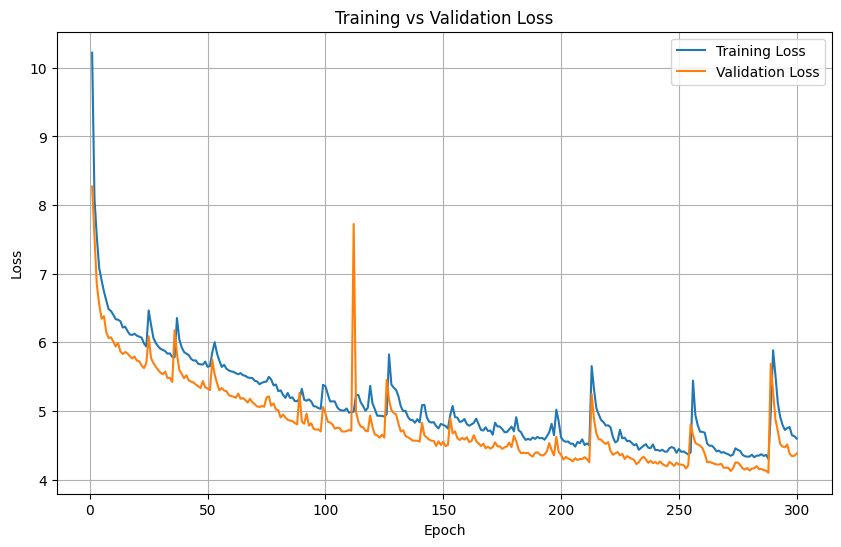


Evaluation Metrics for Top 15 Features (Excluding 'risk increase traffic'):
             target  precision    recall        f1       mcc       auc
0     risk entering   0.681287  0.591220  0.613508  0.336209  0.862360
1  risk circulating   0.834467  0.601478  0.659771  0.524083  0.901417
2      risk exiting   0.521413  0.481206  0.471707  0.454709  0.884060
3  risk single-lane   0.810576  0.585735  0.648792  0.574620  0.948289
4  risk double-lane   0.843823  0.695652  0.715850  0.792252  0.957613
5   risk multi-lane   0.784148  0.722295  0.730436  0.620972  0.934004
6   overall opinion   0.649076  0.413507  0.416604  0.517867  0.861807

Macro-Averaged Metrics (excluding NaN):
   precision    recall        f1       mcc       auc
0   0.732113  0.584442  0.608096  0.545816  0.907079


In [18]:
# Cell 15: Complete Training and Evaluation for Top 15 Features
from sklearn.metrics import precision_recall_fscore_support, matthews_corrcoef
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Exclude 'risk increase traffic'
target_columns_updated = [
    'risk entering', 'risk circulating', 'risk exiting',
    'risk single-lane', 'risk double-lane', 'risk multi-lane',
    'overall opinion'
]

# Prepare data with top 15 features
top_15_features = [
    'chance accident', 'car safety', 'faced accident/near-accident', 'Location',
    'Type accident', 'Day', 'Keep Left signs', 'Roundabout signs',
    'Speed Breakers present', 'Object Hazard sign', 'GIVE WAY lines',
    'lane directional marking', 'Road lighting', 'vehicle category', 'occupation'
]

# Extract top features from dataset
X_top = df[top_15_features].astype(int).values - 1

# Extract updated targets
indices_to_keep = [target_columns.index(t) for t in target_columns_updated]
y_all = df[target_columns].astype(int).values - 1
y_all_updated = y_all[:, indices_to_keep]

# Create new datasets
X_top_tensor = torch.tensor(X_top, dtype=torch.long)
train_size = int(0.8 * len(X_top))
X_top_train, X_top_val = X_top_tensor[:train_size], X_top_tensor[train_size:]
y_train, y_val = y_all_updated[:train_size], y_all_updated[train_size:]

# Create DataLoaders
train_dataset_top = TensorDataset(X_top_train, torch.tensor(y_train, dtype=torch.long))
val_dataset_top = TensorDataset(X_top_val, torch.tensor(y_val, dtype=torch.long))

train_loader_top = DataLoader(train_dataset_top, batch_size=64, shuffle=True)
val_loader_top = DataLoader(val_dataset_top, batch_size=64)

# Reinitialize model with top features and updated target count
new_category_sizes = [category_sizes[categorical_features.index(f)] for f in top_15_features]
num_targets_updated = len(target_columns_updated)
model_top = MultiTargetTabTransformer(new_category_sizes, [5]*num_targets_updated).to(device)

# Training configuration
optimizer = torch.optim.Adam(model_top.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop with 100 epochs and loss tracking
num_epochs = 300
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model_top.train()
    total_loss = 0
    batch_count = 0

    for X_batch, y_batch in train_loader_top:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        outputs = model_top(X_batch)
        loss = 0
        for i in range(num_targets_updated):
            loss += criterion(outputs[i], y_batch[:, i])

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        batch_count += 1

    avg_train_loss = total_loss / batch_count
    train_losses.append(avg_train_loss)

    # Validation loss
    model_top.eval()
    val_loss = 0
    val_batch_count = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader_top:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model_top(X_batch)
            batch_loss = 0
            for i in range(num_targets_updated):
                batch_loss += criterion(outputs[i], y_batch[:, i]).item()
            val_loss += batch_loss
            val_batch_count += 1

    avg_val_loss = val_loss / val_batch_count
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Fixed metrics calculation
def compute_metrics(model, data_loader, device, num_targets):
    model.eval()
    all_preds = [[] for _ in range(num_targets)]
    all_probs = [[] for _ in range(num_targets)]
    all_true = [[] for _ in range(num_targets)]

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)

            for i in range(num_targets):
                probs = torch.softmax(outputs[i], dim=1)
                preds = torch.argmax(probs, dim=1)

                all_preds[i].extend(preds.cpu().numpy())
                all_probs[i].extend(probs.cpu().numpy())
                all_true[i].extend(y_batch[:, i].cpu().numpy())

    metrics = []
    for i in range(num_targets):
        y_true = np.array(all_true[i])
        y_pred = np.array(all_preds[i])
        y_prob = np.array(all_probs[i])

        # Precision, Recall, F1 (macro averaged)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='macro', zero_division=0)

        # MCC
        mcc = matthews_corrcoef(y_true, y_pred)

        # AUC with class validation
        unique_classes = np.unique(y_true)
        n_classes = len(unique_classes)

        if n_classes > 1:  # AUC requires at least 2 classes
            lb = LabelBinarizer()
            y_true_bin = lb.fit_transform(y_true)

            # Handle different number of classes
            if y_prob.shape[1] > n_classes:
                y_prob = y_prob[:, :n_classes]
            elif y_prob.shape[1] < n_classes:
                padding = np.zeros((y_prob.shape[0], n_classes - y_prob.shape[1]))
                y_prob = np.hstack([y_prob, padding])

            try:
                auc = roc_auc_score(y_true_bin, y_prob, multi_class='ovr', average='macro')
            except:
                auc = float('nan')
        else:
            auc = float('nan')

        metrics.append({
            'target': target_columns_updated[i],
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'mcc': mcc,
            'auc': auc
        })

    return metrics

# Compute metrics
metrics_results = compute_metrics(model_top, val_loader_top, device, num_targets_updated)

# Create and display results table
results_df = pd.DataFrame(metrics_results)
print("\nEvaluation Metrics for Top 15 Features (Excluding 'risk increase traffic'):")
print(results_df)

# Compute macro-averaged metrics
valid_metrics = results_df.dropna()
macro_avg = {
    'precision': valid_metrics['precision'].mean(),
    'recall': valid_metrics['recall'].mean(),
    'f1': valid_metrics['f1'].mean(),
    'mcc': valid_metrics['mcc'].mean(),
    'auc': valid_metrics['auc'].mean() if not valid_metrics['auc'].isna().all() else float('nan')
}
print("\nMacro-Averaged Metrics (excluding NaN):")
print(pd.DataFrame([macro_avg]))


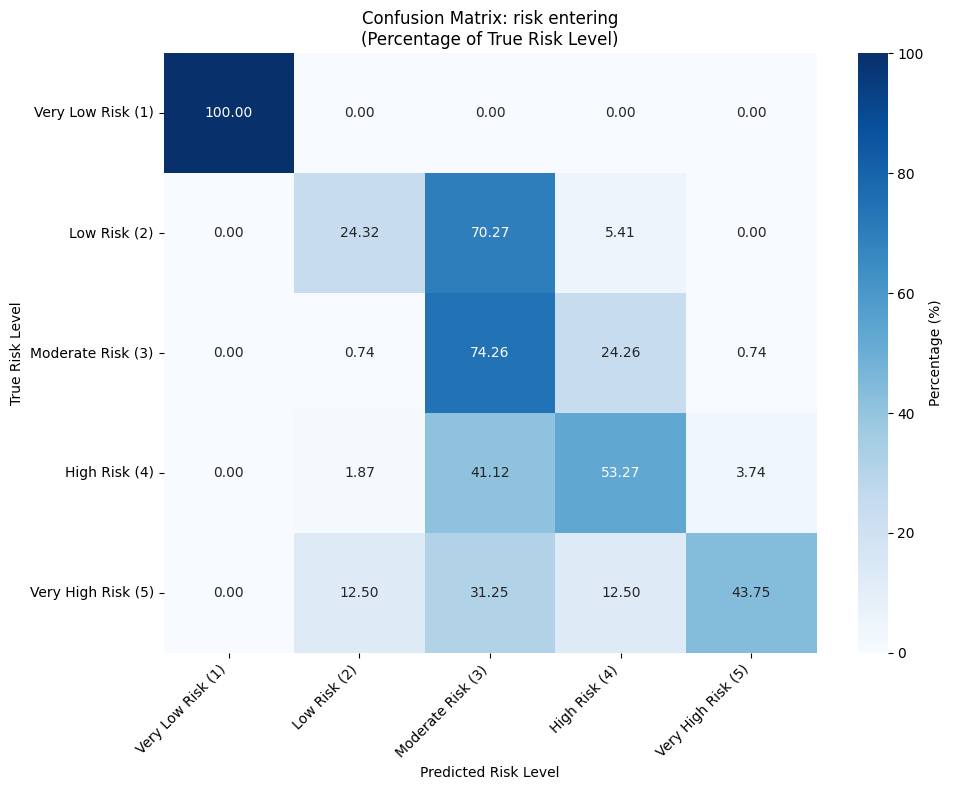

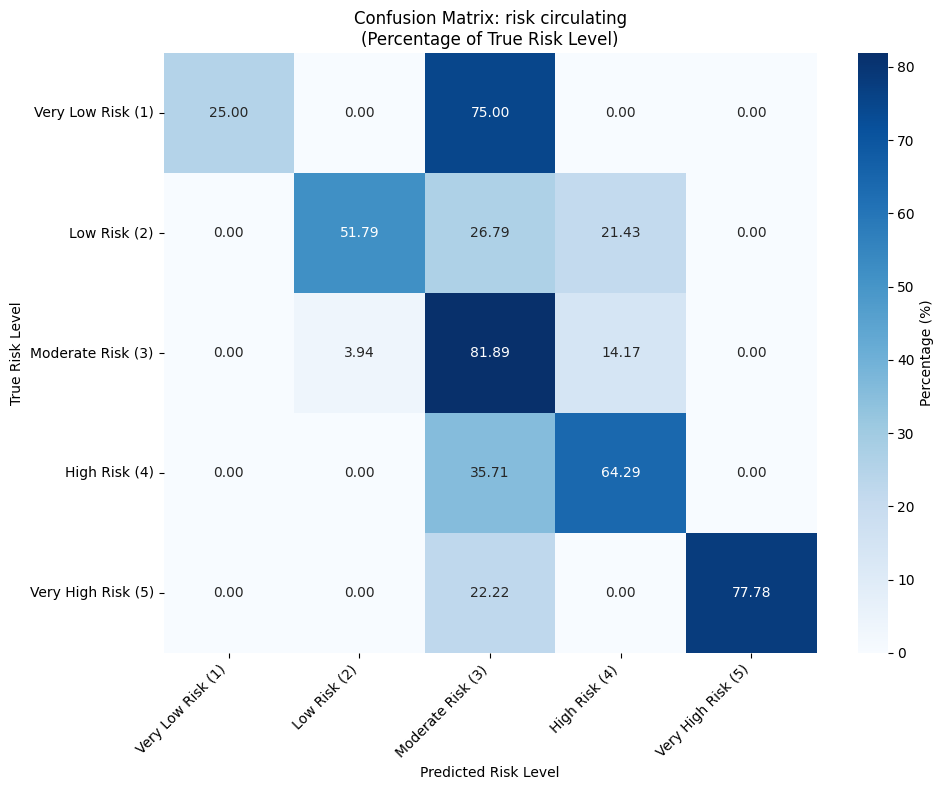

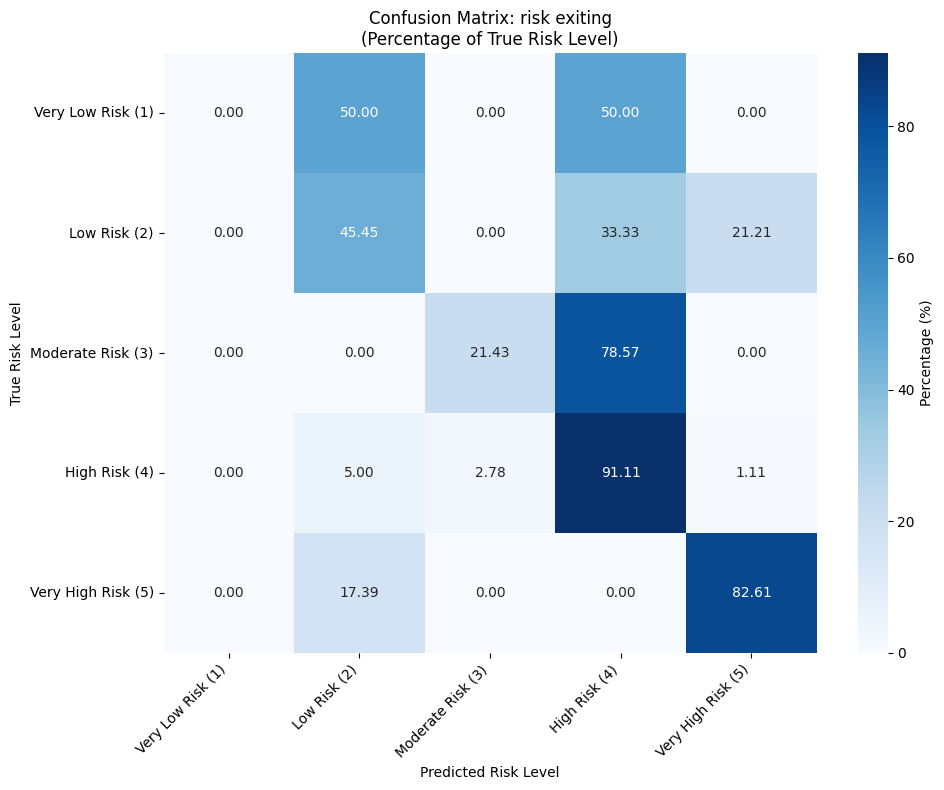

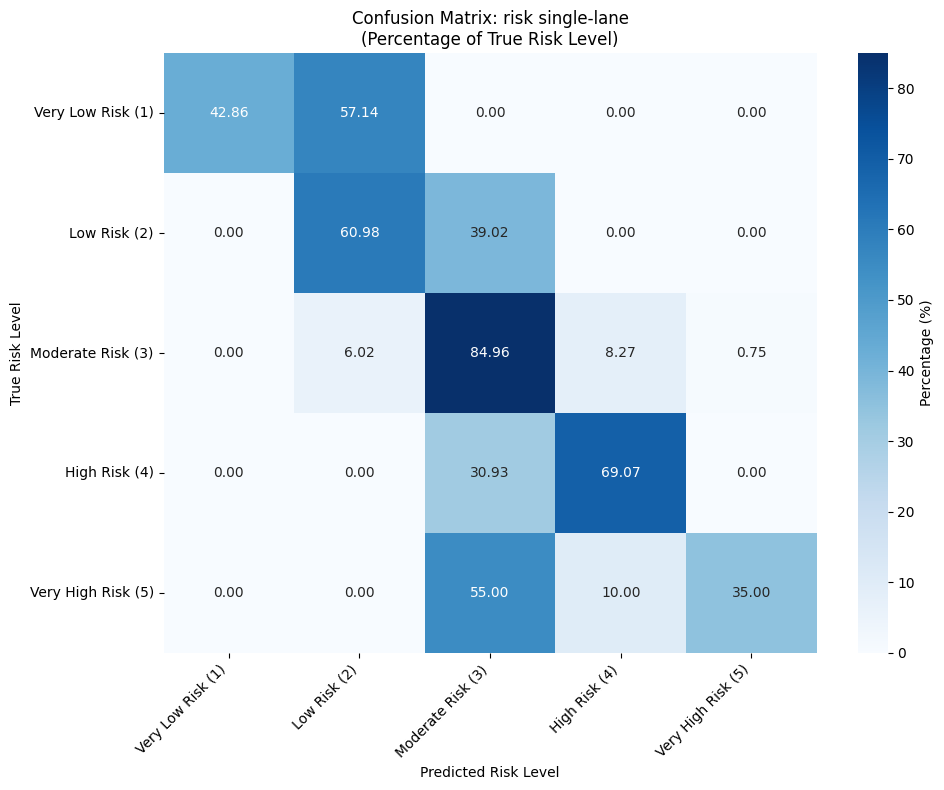

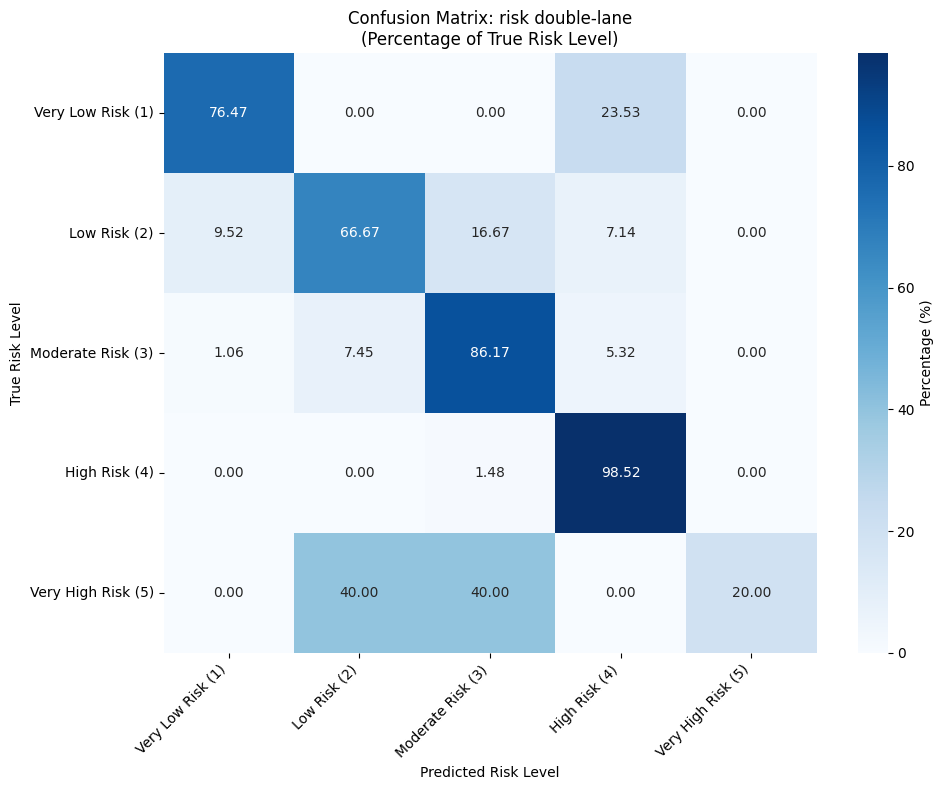

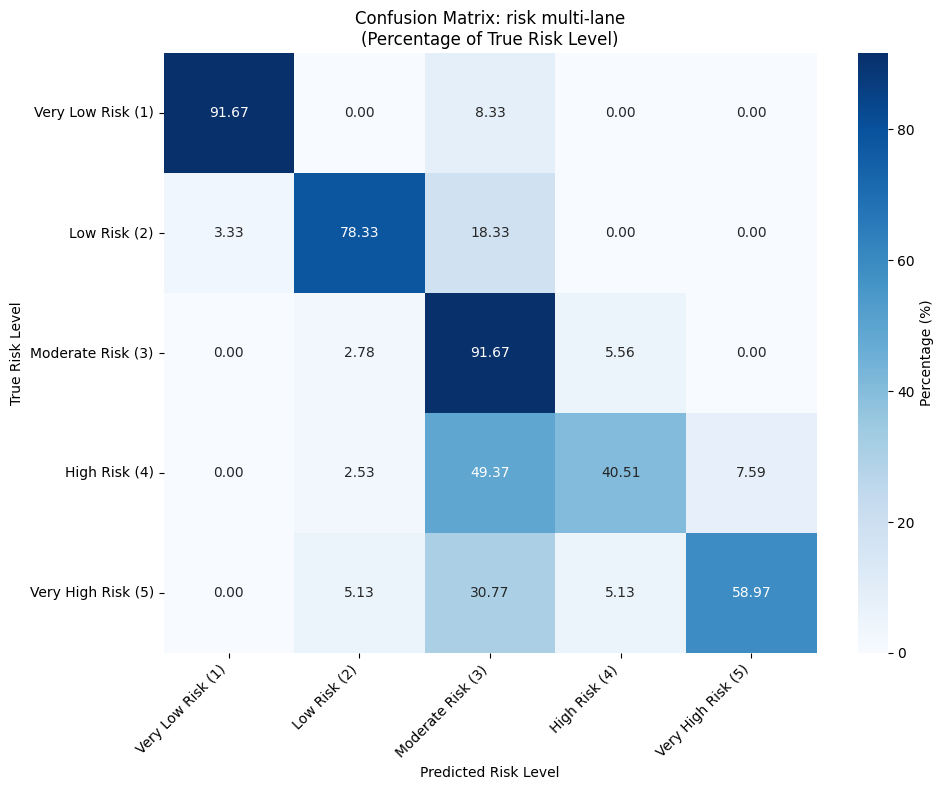

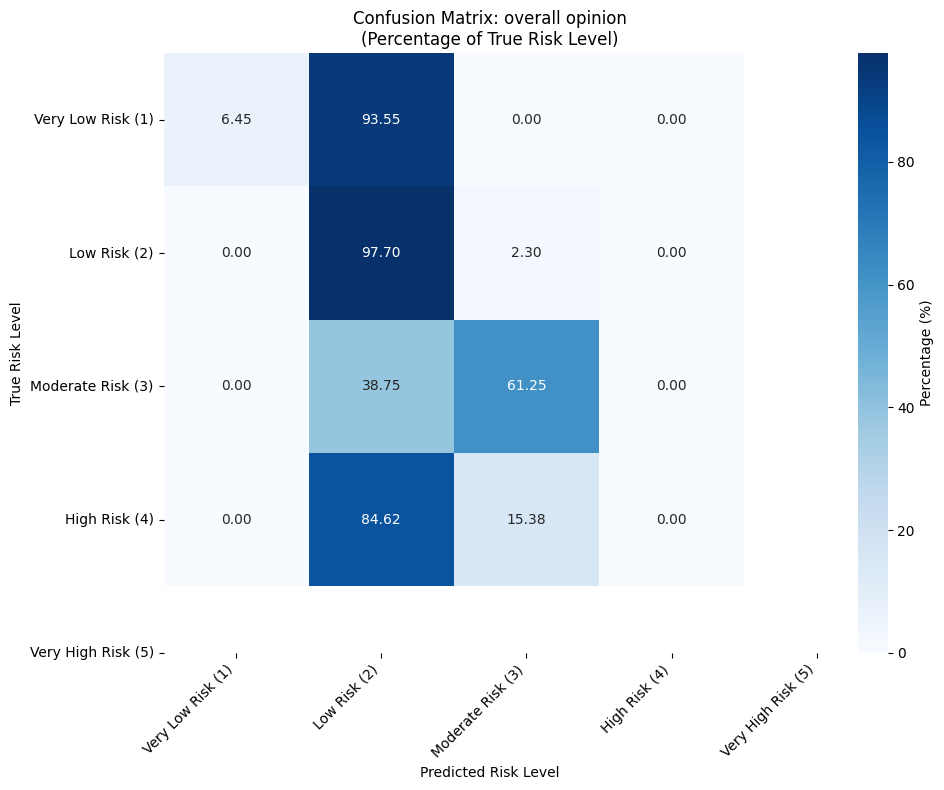

In [19]:
# Cell 16: Confusion Matrix Visualization
def plot_confusion_matrices_percentage(model, data_loader, target_names, device):
    """
    Plots confusion matrices for each target in percentage format with clear risk level labels
    """
    # Define meaningful class labels for risk levels
    risk_levels = [
        'Very Low Risk (1)',
        'Low Risk (2)',
        'Moderate Risk (3)',
        'High Risk (4)',
        'Very High Risk (5)'
    ]

    model.eval()
    all_preds = [[] for _ in range(len(target_names))]
    all_targets = [[] for _ in range(len(target_names))]

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)

            for i in range(len(target_names)):
                _, preds = torch.max(outputs[i], 1)
                all_preds[i].extend(preds.cpu().numpy())
                all_targets[i].extend(y_batch[:, i].cpu().numpy())

    # Plot confusion matrix for each target
    for i, target_name in enumerate(target_names):
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(all_targets[i], all_preds[i])

        # Calculate percentages
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        # Create heatmap with meaningful labels
        sns.heatmap(cm_percent,
                    annot=True,
                    fmt='.2f',
                    cmap='Blues',
                    cbar_kws={'label': 'Percentage (%)'},
                    xticklabels=risk_levels,
                    yticklabels=risk_levels)

        plt.title(f'Confusion Matrix: {target_name}\n(Percentage of True Risk Level)')
        plt.xlabel('Predicted Risk Level')
        plt.ylabel('True Risk Level')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

# Generate confusion matrices
plot_confusion_matrices_percentage(model_top, val_loader_top, target_columns_updated, device)


Epoch 1/1000, Train Loss: 10.9449, Val Loss: 8.7463
Epoch 2/1000, Train Loss: 8.4311, Val Loss: 7.6589
Epoch 3/1000, Train Loss: 7.6479, Val Loss: 6.9238
Epoch 4/1000, Train Loss: 7.1540, Val Loss: 6.5795
Epoch 5/1000, Train Loss: 6.9090, Val Loss: 6.4247
Epoch 6/1000, Train Loss: 6.8040, Val Loss: 6.3371
Epoch 7/1000, Train Loss: 6.7552, Val Loss: 6.2742
Epoch 8/1000, Train Loss: 6.6295, Val Loss: 6.1600
Epoch 9/1000, Train Loss: 6.5339, Val Loss: 6.0937
Epoch 10/1000, Train Loss: 6.4213, Val Loss: 6.0550
Epoch 11/1000, Train Loss: 6.4453, Val Loss: 5.9778
Epoch 12/1000, Train Loss: 6.3001, Val Loss: 5.8810
Epoch 13/1000, Train Loss: 6.2225, Val Loss: 5.8248
Epoch 14/1000, Train Loss: 6.1801, Val Loss: 5.7990
Epoch 15/1000, Train Loss: 6.1761, Val Loss: 5.7913
Epoch 16/1000, Train Loss: 6.1423, Val Loss: 5.7281
Epoch 17/1000, Train Loss: 6.0891, Val Loss: 5.6984
Epoch 18/1000, Train Loss: 6.0238, Val Loss: 5.7169
Epoch 19/1000, Train Loss: 5.9977, Val Loss: 5.6255
Epoch 20/1000, Train

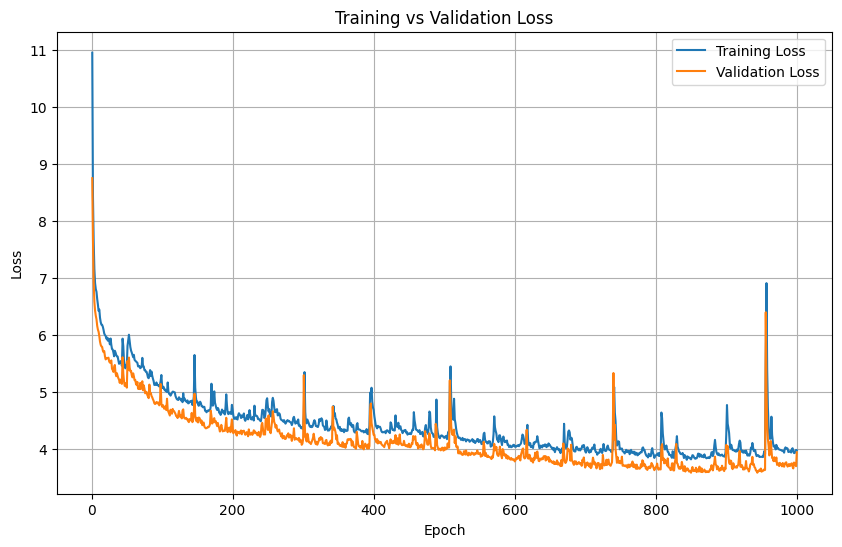


Evaluation Metrics for Top 15 Features (Excluding 'risk increase traffic'):
             target  precision    recall        f1       mcc       auc
0     risk entering   0.770565  0.766449  0.758926  0.606615  0.962751
1  risk circulating   0.844770  0.708143  0.739920  0.549029  0.913091
2      risk exiting   0.756902  0.792060  0.768738  0.626729  0.928810
3  risk single-lane   0.659377  0.613534  0.630085  0.559547  0.930356
4  risk double-lane   0.845856  0.841664  0.834047  0.795759  0.978723
5   risk multi-lane   0.733771  0.689616  0.687576  0.596442  0.924305
6   overall opinion   0.858910  0.468473  0.469893  0.549623  0.872637

Macro-Averaged Metrics (excluding NaN):
   precision    recall        f1       mcc       auc
0    0.78145  0.697134  0.698455  0.611963  0.930096


In [20]:
# Cell 15: Complete Training and Evaluation for Top 15 Features
from sklearn.metrics import precision_recall_fscore_support, matthews_corrcoef
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Exclude 'risk increase traffic'
target_columns_updated = [
    'risk entering', 'risk circulating', 'risk exiting',
    'risk single-lane', 'risk double-lane', 'risk multi-lane',
    'overall opinion'
]

# Prepare data with top 15 features
top_15_features = [
    'chance accident', 'car safety', 'faced accident/near-accident', 'Location',
    'Type accident', 'Day', 'Keep Left signs', 'Roundabout signs',
    'Speed Breakers present', 'Object Hazard sign', 'GIVE WAY lines',
    'lane directional marking', 'Road lighting', 'vehicle category', 'occupation'
]

# Extract top features from dataset
X_top = df[top_15_features].astype(int).values - 1

# Extract updated targets
indices_to_keep = [target_columns.index(t) for t in target_columns_updated]
y_all = df[target_columns].astype(int).values - 1
y_all_updated = y_all[:, indices_to_keep]

# Create new datasets
X_top_tensor = torch.tensor(X_top, dtype=torch.long)
train_size = int(0.8 * len(X_top))
X_top_train, X_top_val = X_top_tensor[:train_size], X_top_tensor[train_size:]
y_train, y_val = y_all_updated[:train_size], y_all_updated[train_size:]

# Create DataLoaders
train_dataset_top = TensorDataset(X_top_train, torch.tensor(y_train, dtype=torch.long))
val_dataset_top = TensorDataset(X_top_val, torch.tensor(y_val, dtype=torch.long))

train_loader_top = DataLoader(train_dataset_top, batch_size=64, shuffle=True)
val_loader_top = DataLoader(val_dataset_top, batch_size=64)

# Reinitialize model with top features and updated target count
new_category_sizes = [category_sizes[categorical_features.index(f)] for f in top_15_features]
num_targets_updated = len(target_columns_updated)
model_top = MultiTargetTabTransformer(new_category_sizes, [5]*num_targets_updated).to(device)

# Training configuration
optimizer = torch.optim.Adam(model_top.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop with 100 epochs and loss tracking
num_epochs = 1000
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model_top.train()
    total_loss = 0
    batch_count = 0

    for X_batch, y_batch in train_loader_top:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        outputs = model_top(X_batch)
        loss = 0
        for i in range(num_targets_updated):
            loss += criterion(outputs[i], y_batch[:, i])

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        batch_count += 1

    avg_train_loss = total_loss / batch_count
    train_losses.append(avg_train_loss)

    # Validation loss
    model_top.eval()
    val_loss = 0
    val_batch_count = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader_top:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model_top(X_batch)
            batch_loss = 0
            for i in range(num_targets_updated):
                batch_loss += criterion(outputs[i], y_batch[:, i]).item()
            val_loss += batch_loss
            val_batch_count += 1

    avg_val_loss = val_loss / val_batch_count
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Fixed metrics calculation
def compute_metrics(model, data_loader, device, num_targets):
    model.eval()
    all_preds = [[] for _ in range(num_targets)]
    all_probs = [[] for _ in range(num_targets)]
    all_true = [[] for _ in range(num_targets)]

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)

            for i in range(num_targets):
                probs = torch.softmax(outputs[i], dim=1)
                preds = torch.argmax(probs, dim=1)

                all_preds[i].extend(preds.cpu().numpy())
                all_probs[i].extend(probs.cpu().numpy())
                all_true[i].extend(y_batch[:, i].cpu().numpy())

    metrics = []
    for i in range(num_targets):
        y_true = np.array(all_true[i])
        y_pred = np.array(all_preds[i])
        y_prob = np.array(all_probs[i])

        # Precision, Recall, F1 (macro averaged)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='macro', zero_division=0)

        # MCC
        mcc = matthews_corrcoef(y_true, y_pred)

        # AUC with class validation
        unique_classes = np.unique(y_true)
        n_classes = len(unique_classes)

        if n_classes > 1:  # AUC requires at least 2 classes
            lb = LabelBinarizer()
            y_true_bin = lb.fit_transform(y_true)

            # Handle different number of classes
            if y_prob.shape[1] > n_classes:
                y_prob = y_prob[:, :n_classes]
            elif y_prob.shape[1] < n_classes:
                padding = np.zeros((y_prob.shape[0], n_classes - y_prob.shape[1]))
                y_prob = np.hstack([y_prob, padding])

            try:
                auc = roc_auc_score(y_true_bin, y_prob, multi_class='ovr', average='macro')
            except:
                auc = float('nan')
        else:
            auc = float('nan')

        metrics.append({
            'target': target_columns_updated[i],
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'mcc': mcc,
            'auc': auc
        })

    return metrics

# Compute metrics
metrics_results = compute_metrics(model_top, val_loader_top, device, num_targets_updated)

# Create and display results table
results_df = pd.DataFrame(metrics_results)
print("\nEvaluation Metrics for Top 15 Features (Excluding 'risk increase traffic'):")
print(results_df)

# Compute macro-averaged metrics
valid_metrics = results_df.dropna()
macro_avg = {
    'precision': valid_metrics['precision'].mean(),
    'recall': valid_metrics['recall'].mean(),
    'f1': valid_metrics['f1'].mean(),
    'mcc': valid_metrics['mcc'].mean(),
    'auc': valid_metrics['auc'].mean() if not valid_metrics['auc'].isna().all() else float('nan')
}
print("\nMacro-Averaged Metrics (excluding NaN):")
print(pd.DataFrame([macro_avg]))


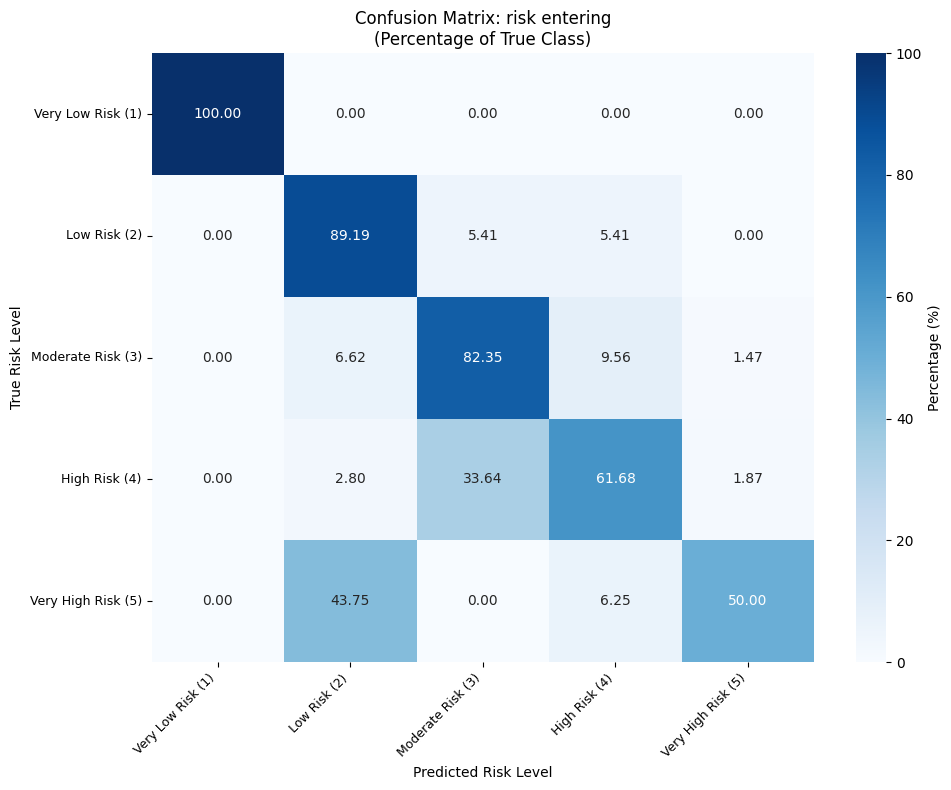

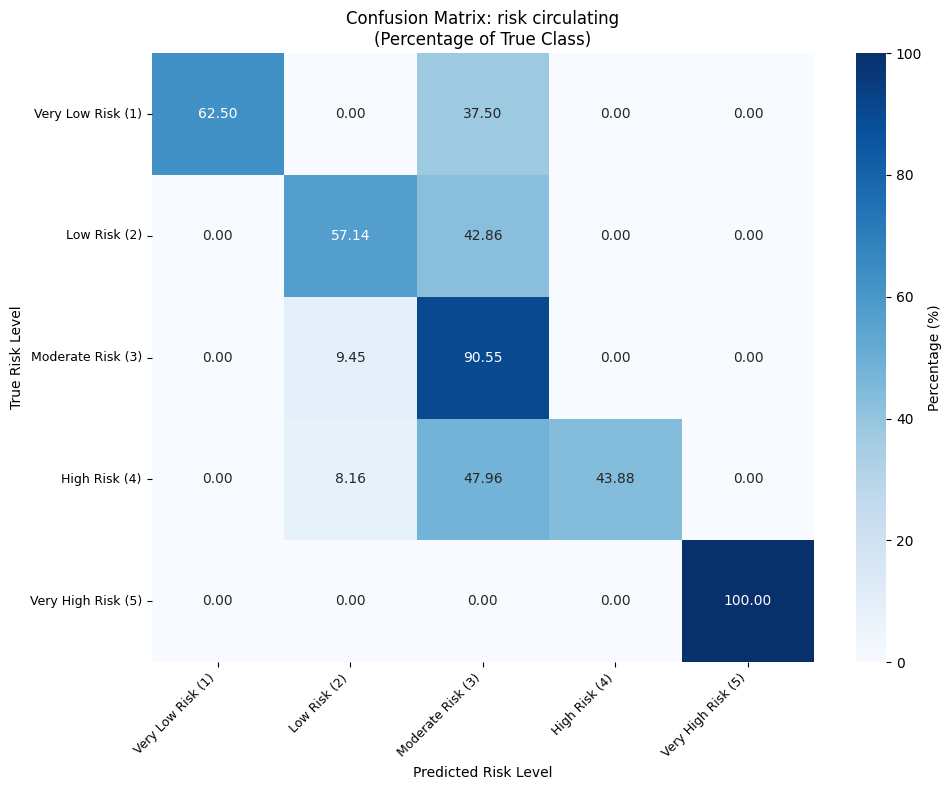

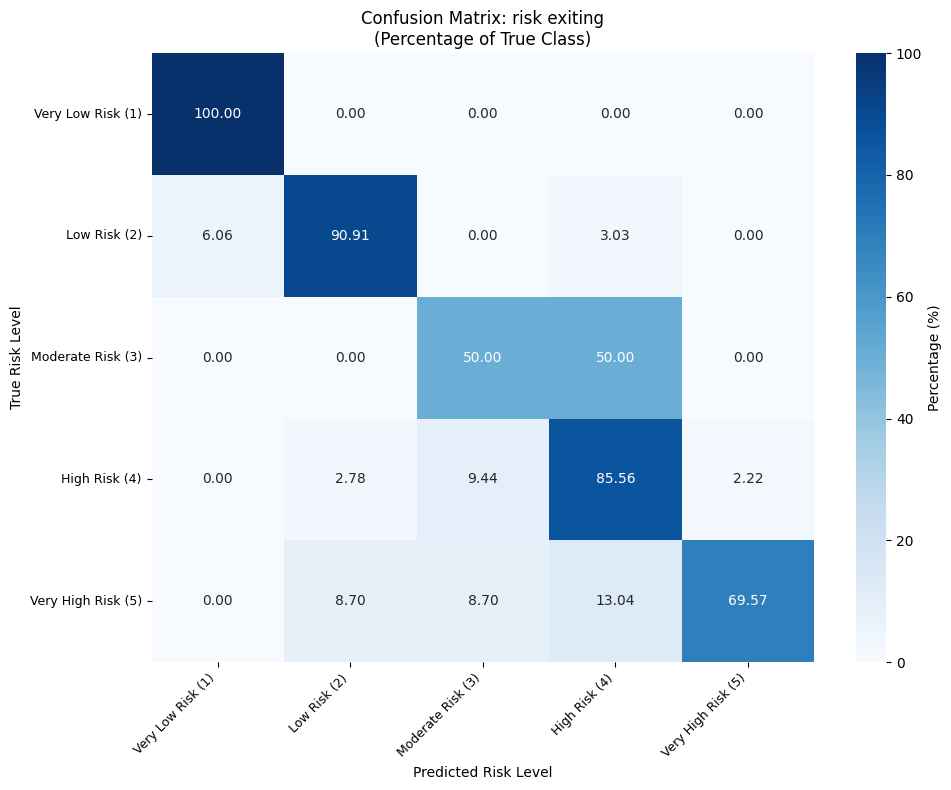

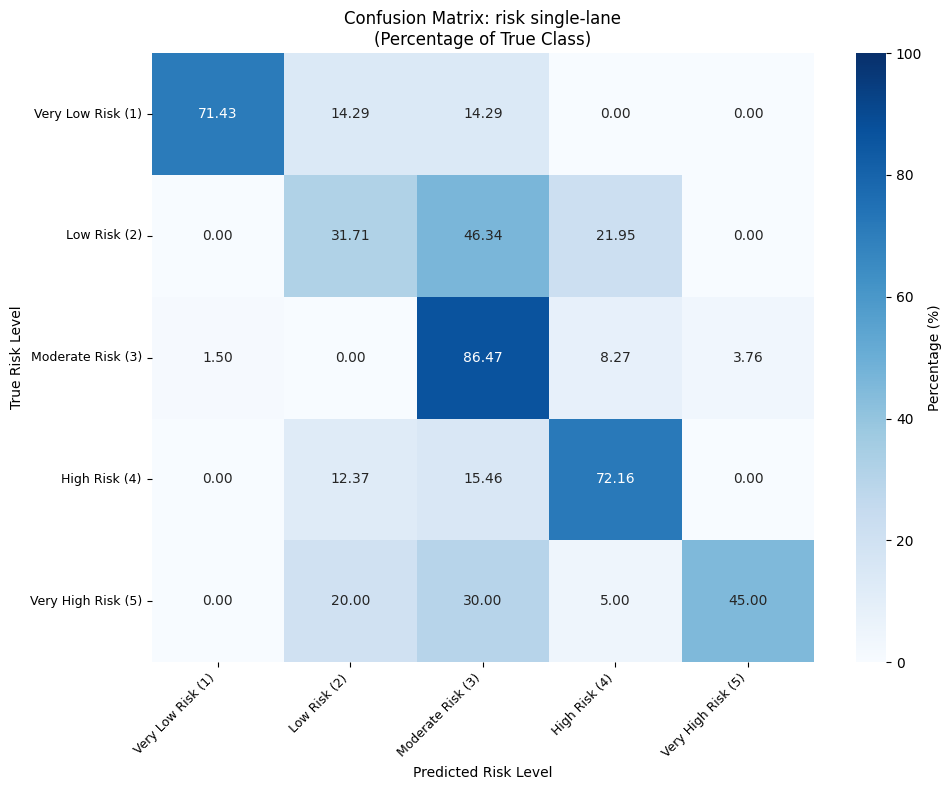

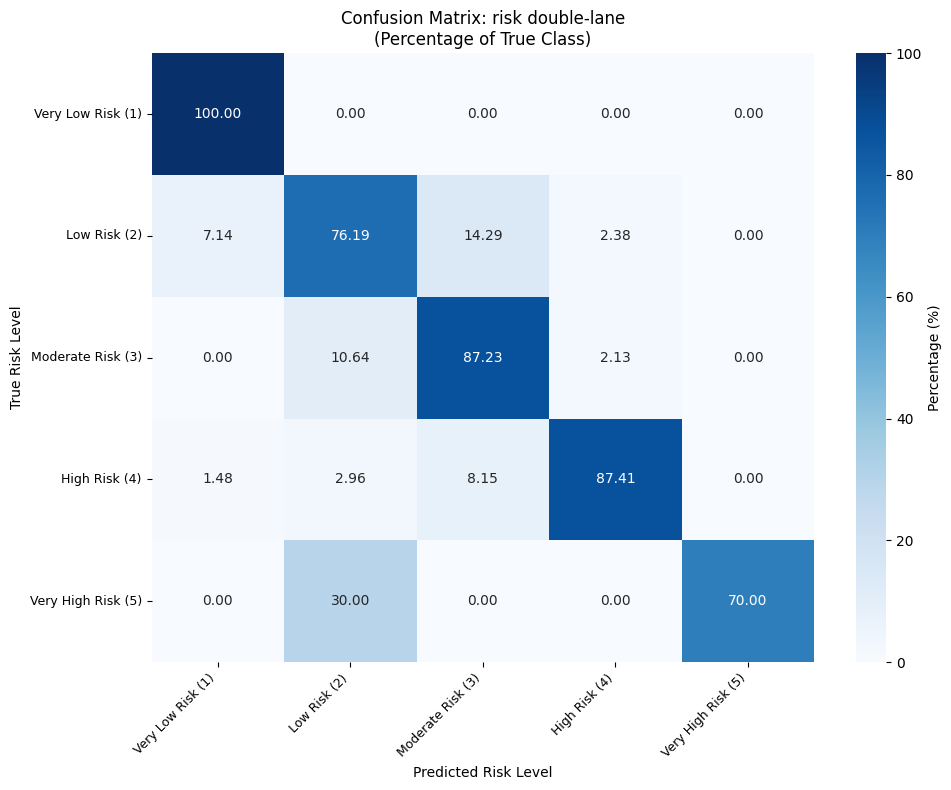

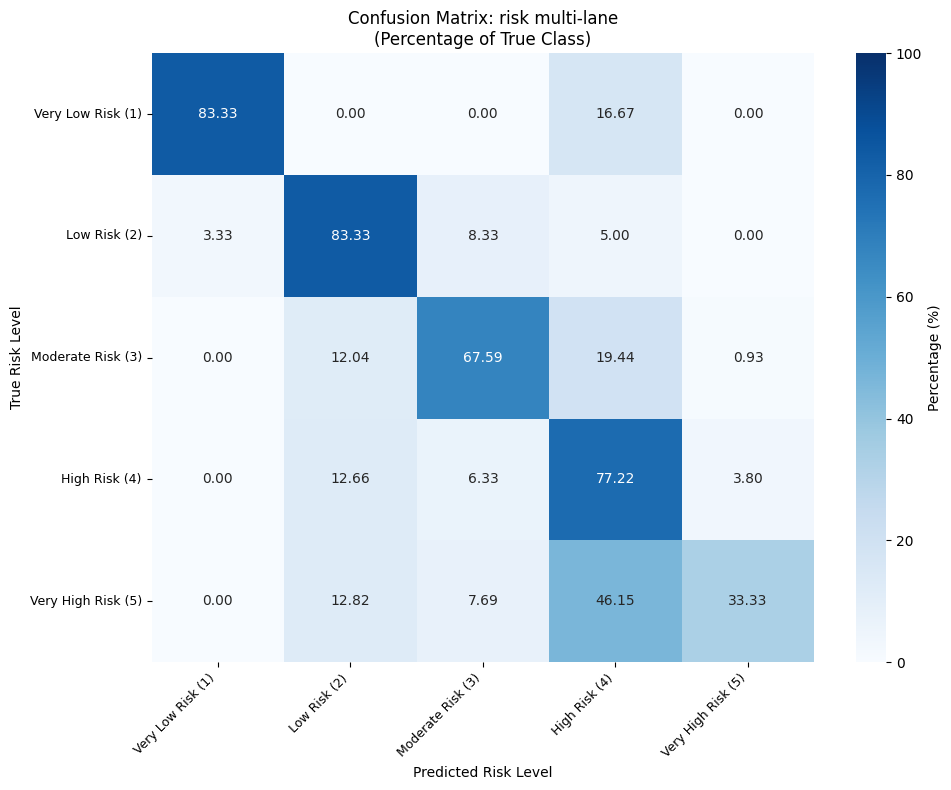

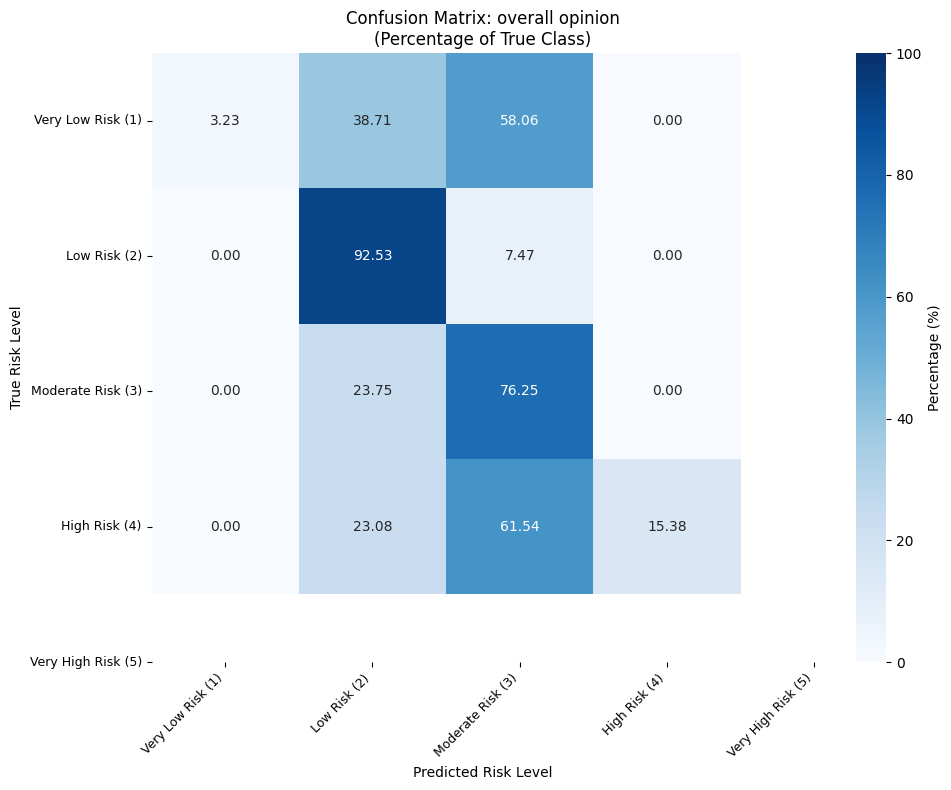

In [21]:
# Cell 16: Confusion Matrix Visualization
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices_percentage(model, data_loader, target_names, device):
    """
    Plots confusion matrices for each target in percentage format
    """
    # Define risk level labels
    risk_levels = [
        'Very Low Risk (1)',
        'Low Risk (2)',
        'Moderate Risk (3)',
        'High Risk (4)',
        'Very High Risk (5)'
    ]

    model.eval()
    all_preds = [[] for _ in range(len(target_names))]
    all_targets = [[] for _ in range(len(target_names))]

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)

            for i in range(len(target_names)):
                _, preds = torch.max(outputs[i], 1)
                all_preds[i].extend(preds.cpu().numpy())
                all_targets[i].extend(y_batch[:, i].cpu().numpy())

    # Plot confusion matrix for each target
    for i, target_name in enumerate(target_names):
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(all_targets[i], all_preds[i])

        # Calculate percentages
        with np.errstate(invalid='ignore'):  # Ignore division by zero
            cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
            cm_percent = np.nan_to_num(cm_percent, nan=0.0)

        # Create heatmap
        sns.heatmap(
            cm_percent,
            annot=True,
            fmt='.2f',
            cmap='Blues',
            cbar_kws={'label': 'Percentage (%)'},
            xticklabels=risk_levels,
            yticklabels=risk_levels,
            vmin=0,
            vmax=100
        )

        plt.title(f'Confusion Matrix: {target_name}\n(Percentage of True Class)')
        plt.xlabel('Predicted Risk Level')
        plt.ylabel('True Risk Level')
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.yticks(rotation=0, fontsize=9)
        plt.tight_layout()
        plt.show()

# Generate confusion matrices
plot_confusion_matrices_percentage(model_top, val_loader_top, target_columns_updated, device)


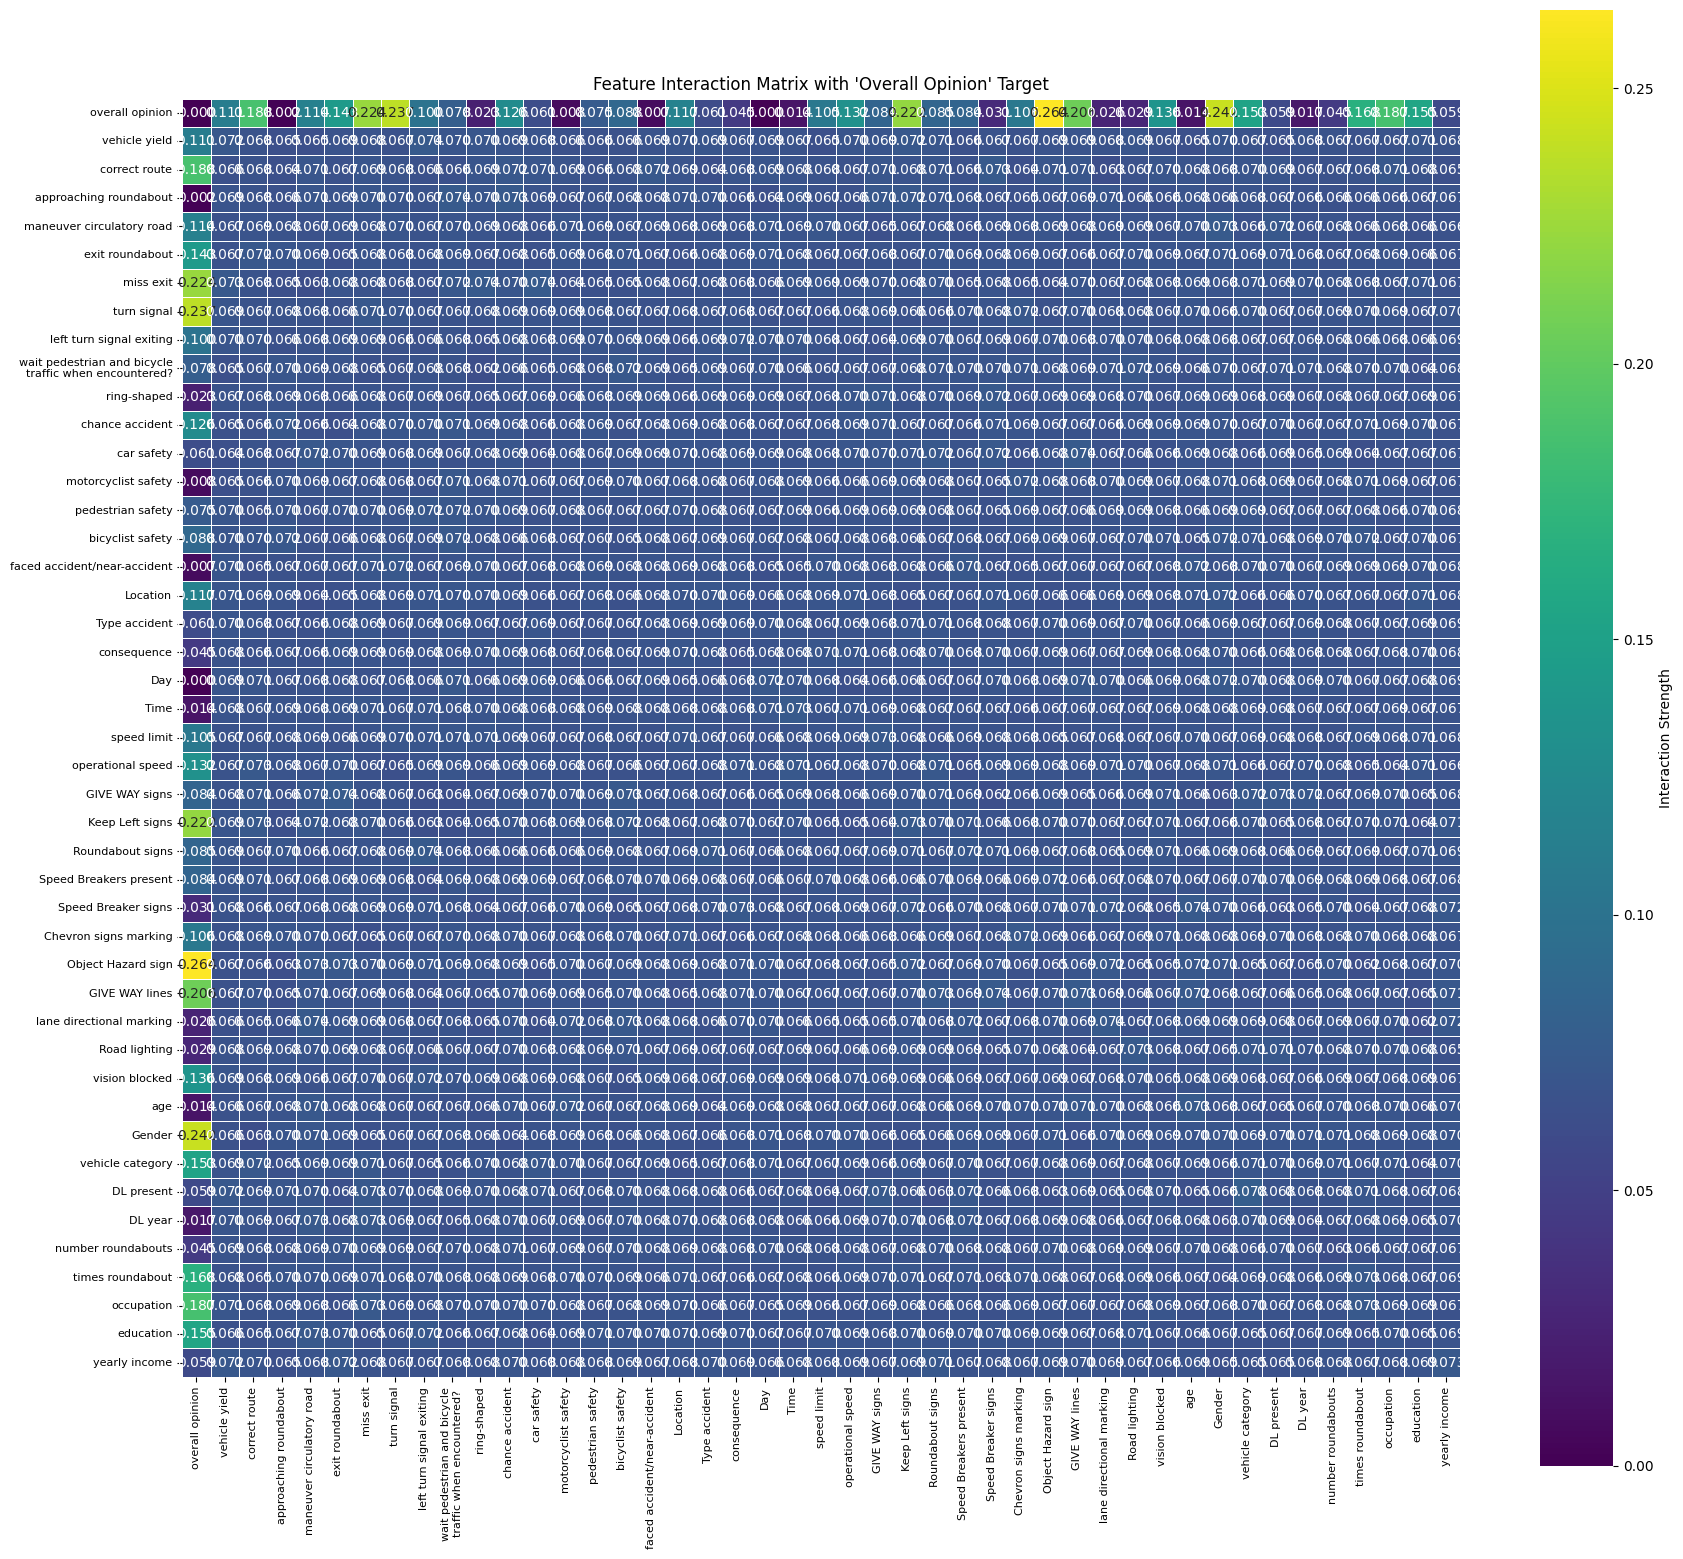


Top Feature Interactions (Including Overall Opinion):
Found 291 interactions above threshold 0.0703

Top 15 interactions:
overall opinion -> Object Hazard sign: 0.2642
Object Hazard sign -> overall opinion: 0.2642
overall opinion -> Gender: 0.2420
Gender -> overall opinion: 0.2420
overall opinion -> turn signal: 0.2374
turn signal -> overall opinion: 0.2374
overall opinion -> miss exit: 0.2237
miss exit -> overall opinion: 0.2237
overall opinion -> Keep Left signs: 0.2217
Keep Left signs -> overall opinion: 0.2217
overall opinion -> GIVE WAY lines: 0.2055
GIVE WAY lines -> overall opinion: 0.2055
overall opinion -> correct route: 0.1877
correct route -> overall opinion: 0.1877
overall opinion -> occupation: 0.1866

Top 10 interactions involving 'overall opinion':
overall opinion -> Object Hazard sign: 0.2642
Object Hazard sign -> overall opinion: 0.2642
overall opinion -> Gender: 0.2420
Gender -> overall opinion: 0.2420
overall opinion -> turn signal: 0.2374
turn signal -> overall opi

In [22]:
# Cell 12: Feature Interaction Analysis with Target Variable Integration
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Redefine model with attention return capability
class MultiTargetTabTransformer(nn.Module):
    def __init__(self, category_sizes, num_classes_per_target):
        super().__init__()
        self.backbone = TabTransformer(
            categories=category_sizes,
            num_continuous=0,
            dim=32,
            depth=4,
            heads=8,
            attn_dropout=0.1,
            ff_dropout=0.1
        )
        self.projection = nn.LazyLinear(32)
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(32, 64),
                nn.ReLU(),
                nn.Linear(64, num_classes)
            ) for num_classes in num_classes_per_target
        ])

    def forward(self, x_categorical, return_attention=False):
        x_cont = torch.empty(x_categorical.size(0), 0, device=x_categorical.device)
        x, attn_weights = self.backbone(x_categorical, x_cont, return_attn=True)

        if x.dim() == 3:
            x = x.mean(dim=1)
        elif x.dim() == 1:
            x = x.unsqueeze(0)
        if x.dim() != 2:
            x = x.view(x.size(0), -1)
        x = self.projection(x)

        if return_attention:
            return [head(x) for head in self.heads], attn_weights
        return [head(x) for head in self.heads]

# 2. Reinitialize model with attention capability
num_classes_per_target = [5] * 8
new_model = MultiTargetTabTransformer(category_sizes, num_classes_per_target).to(device)
new_model.load_state_dict(torch.load("best_model.pth"))

# 3. Compute attention matrix between features
def compute_attention_map(model, data_loader, device):
    model.eval()
    all_attentions = []

    with torch.no_grad():
        for X_batch, _ in data_loader:
            X_batch = X_batch.to(device)
            _, attn_weights = model(X_batch, return_attention=True)

            batch_attentions = []
            for layer_attn in attn_weights:
                layer_avg = layer_attn.mean(dim=1)
                batch_attentions.append(layer_avg)

            batch_attentions = torch.stack(batch_attentions, dim=0)
            layer_weights = torch.linspace(1, 0.5, len(batch_attentions)).to(device)
            weighted_attn = (batch_attentions * layer_weights.view(-1, 1, 1, 1)).sum(dim=0)
            all_attentions.append(weighted_attn.cpu())

    full_attention = torch.cat(all_attentions, dim=0)
    return full_attention.mean(dim=0)

# 4. Compute feature-target correlations for "overall opinion"
def compute_feature_target_correlations(model, data_loader, device, target_idx=7):  # overall opinion index
    model.eval()
    all_features = []
    all_predictions = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)

            # Get predictions for overall opinion (target_idx=7)
            predictions = torch.softmax(outputs[target_idx], dim=1)
            predicted_classes = torch.argmax(predictions, dim=1)

            all_features.append(X_batch.cpu().numpy())
            all_predictions.append(predicted_classes.cpu().numpy())

    # Concatenate all batches
    all_features = np.concatenate(all_features, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)

    # Compute correlations between each feature and overall opinion predictions
    feature_correlations = []
    for i in range(all_features.shape[1]):
        correlation = np.corrcoef(all_features[:, i], all_predictions)[0, 1]
        # Handle NaN correlations (when variance is 0)
        if np.isnan(correlation):
            correlation = 0.0
        feature_correlations.append(abs(correlation))  # Use absolute correlation

    return np.array(feature_correlations)

# Compute attention matrix and feature-target correlations
attention_matrix = compute_attention_map(new_model, val_loader, device)
target_correlations = compute_feature_target_correlations(new_model, val_loader, device)

# 5. Create extended matrix with "overall opinion" at the top
# Convert attention matrix to numpy
attention_np = attention_matrix.numpy()

# Create new matrix with one extra row and column for "overall opinion"
new_size = attention_np.shape[0] + 1
extended_attention = np.zeros((new_size, new_size))

# Place original attention matrix starting from row 1, col 1
extended_attention[1:, 1:] = attention_np

# Add target correlations as first row and first column (excluding diagonal)
extended_attention[0, 1:] = target_correlations  # First row
extended_attention[1:, 0] = target_correlations  # First column

# Create extended feature list with "overall opinion" at the top
extended_features = ['overall opinion'] + categorical_features

# 6. Visualize extended feature interactions
plt.figure(figsize=(18, 16))
sns.heatmap(
    extended_attention,
    xticklabels=extended_features,
    yticklabels=extended_features,
    cmap="viridis",
    annot=True,
    fmt=".3f",
    linewidths=0.5,
    cbar_kws={'label': 'Interaction Strength'},
    square=True
)
plt.title("Feature Interaction Matrix with 'Overall Opinion' Target")
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

# 7. Identify top interactions including overall opinion
print("\nTop Feature Interactions (Including Overall Opinion):")
interaction_strengths = []

# Use adaptive threshold
threshold = max(0.05, np.percentile(extended_attention[extended_attention > 0], 85))

for i in range(len(extended_features)):
    for j in range(len(extended_features)):
        if i != j and extended_attention[i, j] > threshold:
            interaction_strengths.append((
                f"{extended_features[i]} -> {extended_features[j]}",
                extended_attention[i, j]
            ))

# Sort and display top interactions
interaction_strengths.sort(key=lambda x: x[1], reverse=True)

if len(interaction_strengths) > 0:
    print(f"Found {len(interaction_strengths)} interactions above threshold {threshold:.4f}")
    print("\nTop 15 interactions:")
    for interaction, strength in interaction_strengths[:15]:
        print(f"{interaction}: {strength:.4f}")

    # Specifically show interactions with overall opinion
    opinion_interactions = [x for x in interaction_strengths if 'overall opinion' in x[0]]
    if opinion_interactions:
        print(f"\nTop 10 interactions involving 'overall opinion':")
        for interaction, strength in opinion_interactions[:10]:
            print(f"{interaction}: {strength:.4f}")
else:
    print(f"No interactions found above threshold {threshold:.4f}")
    print(f"Extended matrix range: {extended_attention.min():.4f} to {extended_attention.max():.4f}")

print(f"\nMatrix dimensions: {extended_attention.shape}")
print(f"Feature list length: {len(extended_features)}")
